In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cmcrameri import cm

import os
from pathlib import Path
import shutil
import gzip
import re
import csv

import timeit

In [3]:
# data_path = 'data/simulation_data'
# output_file = 'processed_data/WDBH_data.csv'
# header = "#N,#rv,#rg,#z,#t_snapshot[myr],#M1[MSUN],#M2[MSUN],#k1,#k2,#id1,#id2,#sma[AU],#ecc,#bin_star_radius0[RSUN],#bin_star_radius1[RSUN],#snapshot, #roche_lobe1_calc[RSUN], #roche_lobe2_calc[RSUN],#radrol0,#radrol1"


In [4]:
data_path = 'data/updated_simulation_data'
output_file_all_all = 'processed_data/collisions_all_data.csv'
output_file_all = 'processed_data/allcollisions_GiantBH_data.csv'
output_file_nocollision = 'processed_data/nocollision_GiantBH_data.csv'
output_file_iscollision = 'processed_data/iscollision_GiantBH_data.csv'
#header = "#N,#rv,#rg,#z,#t_snapshot[myr],#M1[MSUN],#M2[MSUN],#k1,#k2,#id1,#id2,#sma[AU],#ecc,#bin_star_radius0[RSUN],#bin_star_radius1[RSUN],#snapshot, #roche_lobe1_calc[RSUN], #roche_lobe2_calc[RSUN],#radrol0,#radrol1"


In [5]:
def parse_collision(log_file):

    with open(log_file, 'r') as f:
        lines = f.readlines()

    parsed_data = []

    for line in lines:
        # Regular expression to extract values
        pattern = r"t=([\d.]+)\s+([\w-]+)\s+idm=(\d+)\(mm=([\d.]+)\)\s+(?:id1=(\d+)\(m1=([\d.]+)\))?(?::id2=(\d+)\(m2=([\d.]+)\))?(?::id3=(\d+)\(m3=([\d.]+)\))?(?::id4=(\d+)\(m4=([\d.]+)\))? \(r=([\d.]+)\)\s+typem=(\d+)\s+type1=(\d+)\s+type2=(\d+)(?:\s+type3=(\d+))?(?:\s+type4=(\d+))?(?:\s+b\[RSUN\]=([\d.]+))?(?:\s+vinf\[km/s\]=([\d.]+))?"

        match = re.match(pattern, line)
        if match:
            row = list(match.groups())
            # Insert mass_merger after id_merger
            row.insert(3, row.pop(3))
            # Replace missing values with '-100'
            for i in range(len(row)):
                if row[i] is None:
                    row[i] = '-100'

            parsed_data.append(row)
    
    return np.array(parsed_data)


def parse_semerge(log_file):

    with open(log_file, 'r') as f:
        lines = f.readlines()

    parsed_data = []

    for line in lines:
        # Regular expression to extract values
        pattern = r"t=(\d+\.\d+) (\w+) idr=(\d+)\(mr=(\d+\.\d+)\) id1=(\d+)\(m1=(\d+\.\d+)\):id2=(\d+)\(m2=(\d+\.\d+)\) \(r=(\d+\.\d+)\) typer=(\d+) type1=(\d+) type2=(\d+)"


        match = re.match(pattern, line)
        if match:
            row = list(match.groups())
            # Insert mass_merger after id_merger
            row.insert(3, row.pop(3))
            # Replace missing values with '-100'
            for i in range(len(row)):
                if row[i] is None:
                    row[i] = '-100'

            parsed_data.append(row)
    
    return np.array(parsed_data)

In [6]:
# all_coll = []
# id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
# id_BH = [14]

# ### Grab all values
# # Loop over all model folders
# for folder in os.listdir(data_path):
#     folder_path = os.path.join(data_path, folder);
#     # Checks is a folder
#     if os.path.isdir(folder_path):
#         # Loops through all the snapshots
#         for subfolder in os.listdir(folder_path):
#             subfolder_path = os.path.join(folder_path, subfolder);
            
#             ### Find the timeunitsmyr conversion value
#             if os.path.isdir(subfolder_path):
#                 for infosubfolder in os.listdir(subfolder_path):
#                     if infosubfolder.endswith('.sh'):
#                         infosubfolder_path = os.path.join(subfolder_path, infosubfolder);
#                         # Read the file
#                         with open(infosubfolder_path, 'r') as file:
#                             lines = file.readlines();

#                         # Extract the value for timeunitsmyr
#                         for line in lines:
#                             if line.startswith('timeunitsmyr'):
#                                 _, value = line.split('=');
#                                 timeunitsmyr = float(value.strip());
#                                 print(timeunitsmyr);
#                                 break
                
#                 for infosubfolder in os.listdir(subfolder_path):
#                     ### Obtain desired data from info files
#                     if infosubfolder.endswith('.collision.log'):
#                         infosubfolder_path = os.path.join(subfolder_path, infosubfolder);
#                         ### Grab the values of the parameters from the file path
#                         # Define the regular expression pattern
#                         pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
#                         # Search for the pattern in the file path
#                         match = re.search(pattern, subfolder_path);
#                         # If a match is found, extract the values and convert them to floats
#                         if match:
#                             mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
#                         else:
#                             print("Pattern not found in the file path.");
                        
#                         # Parse the log file
#                         events_all = parse_collision(infosubfolder_path)
                        
#                         events_all_list = events_all.tolist()

#                         # Time unit conversion
#                         for sublist in events_all_list:
#                             sublist[0] = float(sublist[0]) * timeunitsmyr
                        
#                         # Append the model parameters to the start of each sublist
#                         data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_all_list];
                            
#                         # Append the data to the list of all data
#                         if len(data_list) > 0:
#                             all_coll += data_list;

In [7]:
# def convert_first_element(lst):
#     if lst[0] == '8':
#         lst[0] = 8.0
#     if lst[0] == '16.0':
#         lst[0] = 16
#     if lst[0] == '32.0':
#         lst[0] = 32
#     return lst

# def convert_third_element(lst):
#     if lst[2] == '8':
#         lst[2] = 8.0
#     return lst

# # Load the CSV file into a numpy array
# data = np.loadtxt(output_file_all_all, delimiter=',', dtype=str, skiprows=1)

# numbers = np.array(data)[::, :4]

# str_numbers = []

# for number in numbers:
#     number = convert_first_element(number)
#     number = convert_third_element(number)
#     # Format each number as required
#     formatted_numbers = [f'{num:.1f}' if isinstance(num, float) else f'{num}' for num in number]
    
#     # Join them into the desired string format
#     output_string = f'N{formatted_numbers[0]}_rv{formatted_numbers[1]}_rg{formatted_numbers[2]}_z{formatted_numbers[3]}'
#     str_numbers.append(output_string)

# str_numbers = list(dict.fromkeys(str_numbers))
# str_numbers += str_numbers
# print(str_numbers)



In [8]:
def get_folder_names(directory):
    try:
        # List all entries in the specified directory
        entries = os.listdir(directory)
        
        # Filter out only the folders
        folders = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]
        
        return folders
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Specify the directory
directory_path = r'data/updated_simulation_data'

# Get the list of folder names
str_numbers = get_folder_names(directory_path)

# Print the list of folder names
print("Folder names:", str_numbers)
print("Number of folders:", len(str_numbers))

Folder names: ['N16_rv0.5_rg2.0_z0.002', 'N16_rv0.5_rg2.0_z0.02', 'N16_rv0.5_rg20.0_z0.002', 'N16_rv0.5_rg20.0_z0.02', 'N16_rv0.5_rg8.0_z0.002', 'N16_rv0.5_rg8.0_z0.02', 'N16_rv1.0_rg2.0_z0.0002', 'N16_rv1.0_rg2.0_z0.002', 'N16_rv1.0_rg2.0_z0.02', 'N16_rv1.0_rg20.0_z0.0002', 'N16_rv1.0_rg20.0_z0.002', 'N16_rv1.0_rg20.0_z0.02', 'N16_rv1.0_rg8.0_z0.0002', 'N16_rv1.0_rg8.0_z0.002', 'N16_rv1.0_rg8.0_z0.02', 'N16_rv2.0_rg2.0_z0.0002', 'N16_rv2.0_rg2.0_z0.002', 'N16_rv2.0_rg2.0_z0.02', 'N16_rv2.0_rg20.0_z0.0002', 'N16_rv2.0_rg20.0_z0.002', 'N16_rv2.0_rg20.0_z0.02', 'N16_rv2.0_rg8.0_z0.0002', 'N16_rv2.0_rg8.0_z0.002', 'N16_rv2.0_rg8.0_z0.02', 'N16_rv4.0_rg2.0_z0.0002', 'N16_rv4.0_rg2.0_z0.002', 'N16_rv4.0_rg2.0_z0.02', 'N16_rv4.0_rg20.0_z0.0002', 'N16_rv4.0_rg20.0_z0.002', 'N16_rv4.0_rg20.0_z0.02', 'N16_rv4.0_rg8.0_z0.0002', 'N16_rv4.0_rg8.0_z0.002', 'N16_rv4.0_rg8.0_z0.02', 'N2.0_rv0.5_rg2.0_z0.0002', 'N2.0_rv0.5_rg2.0_z0.002', 'N2.0_rv0.5_rg2.0_z0.02', 'N2.0_rv0.5_rg20.0_z0.0002', 'N2.0_rv0

In [9]:
id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
id_BH = [14]

all_data = []

for str_number in str_numbers:

    #print("Processing model", str_number)
    # Go through each model individually
    collision_path = f'data/updated_simulation_data/{str_number}/info/initial.collision.log'
    conv_path = f'data/updated_simulation_data/{str_number}/info/initial.conv.sh'

    # Read the file
    with open(conv_path, 'r') as file:
        lines = file.readlines();

    # Extract the value for timeunitsmyr
    for line in lines:
        if line.startswith('timeunitsmyr'):
            _, value = line.split('=');
            timeunitsmyr = float(value.strip());
            #print(timeunitsmyr);
            break

    if os.path.exists(collision_path):
        ### Grab the values of the parameters from the file path
        # Define the regular expression pattern
        pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
        # Search for the pattern in the file path
        match = re.search(pattern, str_number);
        # If a match is found, extract the values and convert them to floats
        if match:
            mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
        else:
            print(f"Pattern {str_number} not found in the file path.");
        
        # Parse the log file
        events_all = parse_collision(collision_path)
        
        events_all_list = events_all.tolist()

        # Time unit conversion
        for sublist in events_all_list:
            sublist[0] = float(sublist[0]) * timeunitsmyr
        
        events_all = np.array(events_all_list)

        id_mergers = np.unique(events_all[::, 2].astype(float))
        


        events_GiantBH = events_all


        ### Puts the black hole as the first object
        # Convert the relevant columns to integer for comparison
        column = events_GiantBH[:, 14].astype(int)
        #print(column)
        # Create a boolean mask
        mask = column != 14

        # Swap the values
        temp = np.copy(events_GiantBH[mask, 4])
        events_GiantBH[mask, 4] = events_GiantBH[mask, 6]
        events_GiantBH[mask, 6] = temp

        temp = np.copy(events_GiantBH[mask, 5])
        events_GiantBH[mask, 5] = events_GiantBH[mask, 7]
        events_GiantBH[mask, 7] = temp

        temp = np.copy(events_GiantBH[mask, 14])
        events_GiantBH[mask, 14] = events_GiantBH[mask, 15]
        events_GiantBH[mask, 15] = temp

        # Append the model parameters to the start of each sublist
        data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_GiantBH.tolist()];


        # Append the data to the list of all data
        if len(data_list) > 0:
            all_data += data_list
        
    else:
        print(f"No such file {collision_path}")

headers = ['N','rv','rg','z','time', 'interaction_type', 'id_merger', 'mass_merger', 'id1', 'm1', 'id2', 'm2', 'id3', 'm3', 'id4', 'm4', 
            'r', 'typem', 'type1', 'type2', 'type3', 'type4', 'b[RSUN]', 'vinf[km/s]']

with open(output_file_all_all, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(all_data)

KeyboardInterrupt: 

In [ ]:
id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
id_BH = [14]

all_coll = []

for str_number in str_numbers:

    #print("Processing model", str_number)
    # Go through each model individually
    collision_path = f'data/updated_simulation_data/{str_number}/info/initial.collision.log'
    conv_path = f'data/updated_simulation_data/{str_number}/info/initial.conv.sh'

    # Read the file
    with open(conv_path, 'r') as file:
        lines = file.readlines();

    # Extract the value for timeunitsmyr
    for line in lines:
        if line.startswith('timeunitsmyr'):
            _, value = line.split('=');
            timeunitsmyr = float(value.strip());
            #print(timeunitsmyr);
            break

    if os.path.exists(collision_path):
        ### Grab the values of the parameters from the file path
        # Define the regular expression pattern
        pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
        # Search for the pattern in the file path
        match = re.search(pattern, str_number);
        # If a match is found, extract the values and convert them to floats
        if match:
            mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
        else:
            print(f"Pattern {str_number} not found in the file path.");
        
        # Parse the log file
        events_all = parse_collision(collision_path)
        
        events_all_list = events_all.tolist()

        # Time unit conversion
        for sublist in events_all_list:
            sublist[0] = float(sublist[0]) * timeunitsmyr
        
        events_all = np.array(events_all_list)

        id_mergers = np.unique(events_all[::, 2].astype(float))

        # Check GiantBH
        check_GiantBH = (((np.isin(events_all[:, 14].astype(float), id_BH) & np.isin(events_all[:, 15].astype(float), id_Giant)) | (np.isin(events_all[:, 15].astype(float), id_BH) & np.isin(events_all[:, 14].astype(float), id_Giant))) &
                            (events_all[:, 16].astype(float) == -100) & (events_all[:, 17].astype(float) == -100));
        events_GiantBH = events_all[check_GiantBH];


        ### Puts the black hole as the first object
        # Convert the relevant columns to integer for comparison
        column = events_GiantBH[:, 14].astype(int)
        #print(column)
        # Create a boolean mask
        mask = column != 14

        # Swap the values
        temp = np.copy(events_GiantBH[mask, 4])
        events_GiantBH[mask, 4] = events_GiantBH[mask, 6]
        events_GiantBH[mask, 6] = temp

        temp = np.copy(events_GiantBH[mask, 5])
        events_GiantBH[mask, 5] = events_GiantBH[mask, 7]
        events_GiantBH[mask, 7] = temp

        temp = np.copy(events_GiantBH[mask, 14])
        events_GiantBH[mask, 14] = events_GiantBH[mask, 15]
        events_GiantBH[mask, 15] = temp

        # Append the model parameters to the start of each sublist
        data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_GiantBH.tolist()];


        # Append the data to the list of all data
        if len(data_list) > 0:
            all_coll += data_list
        
    else:
        print(f"No such file {collision_path}")



In [ ]:
headers = ['N','rv','rg','z','time', 'interaction_type', 'id_merger', 'mass_merger', 'id1', 'm1', 'id2', 'm2', 'id3', 'm3', 'id4', 'm4', 
            'r', 'typem', 'type1', 'type2', 'type3', 'type4', 'b[RSUN]', 'vinf[km/s]']

with open(output_file_all, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(all_coll)

In [ ]:
all_coll = []
id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
id_BH = [14]



allevents_notmerger = []

for str_number in str_numbers:

    #print("Processing model", str_number)
    # Go through each model individually
    collision_path = f'data/updated_simulation_data/{str_number}/info/initial.collision.log'
    semerge_path = f'data/updated_simulation_data/{str_number}/info/initial.semergedisrupt.log'
    conv_path = f'data/updated_simulation_data/{str_number}/info/initial.conv.sh'

    # Read the file
    with open(conv_path, 'r') as file:
        lines = file.readlines();

    # Extract the value for timeunitsmyr
    for line in lines:
        if line.startswith('timeunitsmyr'):
            _, value = line.split('=');
            timeunitsmyr = float(value.strip());
            #print(timeunitsmyr);
            break

    if os.path.exists(collision_path):
        ### Grab the values of the parameters from the file path
        # Define the regular expression pattern
        pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
        # Search for the pattern in the file path
        match = re.search(pattern, str_number);
        # If a match is found, extract the values and convert them to floats
        if match:
            mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
        else:
            print(f"Pattern {str_number} not found in the file path.");
        
        # Parse the log file
        events_all = parse_collision(collision_path)
        events_semerge = parse_semerge(semerge_path)

        events_all_list = events_all.tolist()

        # Time unit conversion
        for sublist in events_all_list:
            sublist[0] = float(sublist[0]) * timeunitsmyr
        
        events_all = np.array(events_all_list)

        id_mergers = np.unique(events_all[::, 2].astype(float))
        id_semergedisrupt = np.unique(events_semerge[::, 2].astype(float))

        id_mergers_total = np.append(id_mergers, id_semergedisrupt)

        # Check GiantBH
        check_GiantBH = (((np.isin(events_all[:, 14].astype(float), id_BH) & np.isin(events_all[:, 15].astype(float), id_Giant)) | (np.isin(events_all[:, 15].astype(float), id_BH) & np.isin(events_all[:, 14].astype(float), id_Giant))) &
                            (events_all[:, 16].astype(float) == -100) & (events_all[:, 17].astype(float) == -100));
        events_GiantBH = events_all[check_GiantBH];


        ### Puts the black hole as the first object
        # Convert the relevant columns to integer for comparison
        column = events_GiantBH[:, 14].astype(int)
        #print(column)
        # Create a boolean mask
        mask = column != 14

        # Swap the values
        temp = np.copy(events_GiantBH[mask, 4])
        events_GiantBH[mask, 4] = events_GiantBH[mask, 6]
        events_GiantBH[mask, 6] = temp

        temp = np.copy(events_GiantBH[mask, 5])
        events_GiantBH[mask, 5] = events_GiantBH[mask, 7]
        events_GiantBH[mask, 7] = temp

        temp = np.copy(events_GiantBH[mask, 14])
        events_GiantBH[mask, 14] = events_GiantBH[mask, 15]
        events_GiantBH[mask, 15] = temp


        # Check not merger
        check_notmerger = np.isin(events_GiantBH[:, 6].astype(float), id_mergers_total, invert=True);
        events_notmerger = events_GiantBH[check_notmerger]

        # Append the model parameters to the start of each sublist
        data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_notmerger.tolist()];


        # Append the data to the list of all data
        if len(data_list) > 0:
            allevents_notmerger += data_list
        

    else:
        print(f"No such file {collision_path}")



In [ ]:
headers = ['N','rv','rg','z','time', 'interaction_type', 'id_merger', 'mass_merger', 'id1', 'm1', 'id2', 'm2', 'id3', 'm3', 'id4', 'm4', 
            'r', 'typem', 'type1', 'type2', 'type3', 'type4', 'b[RSUN]', 'vinf[km/s]']

with open(output_file_nocollision, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(allevents_notmerger)

In [ ]:
all_coll = []
id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
id_BH = [14]



allevents_ismerger = []

for str_number in str_numbers:

    #print("Processing model", str_number)
    # Go through each model individually
    collision_path = f'data/updated_simulation_data/{str_number}/info/initial.collision.log'
    semerge_path = f'data/updated_simulation_data/{str_number}/info/initial.semergedisrupt.log'
    conv_path = f'data/updated_simulation_data/{str_number}/info/initial.conv.sh'

    # Read the file
    with open(conv_path, 'r') as file:
        lines = file.readlines();

    # Extract the value for timeunitsmyr
    for line in lines:
        if line.startswith('timeunitsmyr'):
            _, value = line.split('=');
            timeunitsmyr = float(value.strip());
            #print(timeunitsmyr);
            break

    if os.path.exists(collision_path):
        ### Grab the values of the parameters from the file path
        # Define the regular expression pattern
        pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
        # Search for the pattern in the file path
        match = re.search(pattern, str_number);
        # If a match is found, extract the values and convert them to floats
        if match:
            mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
        else:
            print(f"Pattern {str_number} not found in the file path.");
        
        # Parse the log file
        events_all = parse_collision(collision_path)
        events_semerge = parse_semerge(semerge_path)

        events_all_list = events_all.tolist()

        # Time unit conversion
        for sublist in events_all_list:
            sublist[0] = float(sublist[0]) * timeunitsmyr
        
        events_all = np.array(events_all_list)

        id_mergers = np.unique(events_all[::, 2].astype(float))
        id_semergedisrupt = np.unique(events_semerge[::, 2].astype(float))

        id_mergers_total = np.append(id_mergers, id_semergedisrupt)

        # Check GiantBH
        check_GiantBH = (((np.isin(events_all[:, 14].astype(float), id_BH) & np.isin(events_all[:, 15].astype(float), id_Giant)) | (np.isin(events_all[:, 15].astype(float), id_BH) & np.isin(events_all[:, 14].astype(float), id_Giant))) &
                            (events_all[:, 16].astype(float) == -100) & (events_all[:, 17].astype(float) == -100));
        events_GiantBH = events_all[check_GiantBH];


        ### Puts the black hole as the first object
        # Convert the relevant columns to integer for comparison
        column = events_GiantBH[:, 14].astype(int)
        #print(column)
        # Create a boolean mask
        mask = column != 14

        # Swap the values
        temp = np.copy(events_GiantBH[mask, 4])
        events_GiantBH[mask, 4] = events_GiantBH[mask, 6]
        events_GiantBH[mask, 6] = temp

        temp = np.copy(events_GiantBH[mask, 5])
        events_GiantBH[mask, 5] = events_GiantBH[mask, 7]
        events_GiantBH[mask, 7] = temp

        temp = np.copy(events_GiantBH[mask, 14])
        events_GiantBH[mask, 14] = events_GiantBH[mask, 15]
        events_GiantBH[mask, 15] = temp


        # Check not merger
        check_notmerger = np.isin(events_GiantBH[:, 6].astype(float), id_mergers_total, invert=False);
        events_notmerger = events_GiantBH[check_notmerger]

        # Append the model parameters to the start of each sublist
        data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_notmerger.tolist()];


        # Append the data to the list of all data
        if len(data_list) > 0:
            allevents_ismerger += data_list
        

    else:
        print(f"No such file {collision_path}")



In [ ]:
headers = ['N','rv','rg','z','time', 'interaction_type', 'id_merger', 'mass_merger', 'id1', 'm1', 'id2', 'm2', 'id3', 'm3', 'id4', 'm4', 
            'r', 'typem', 'type1', 'type2', 'type3', 'type4', 'b[RSUN]', 'vinf[km/s]']

with open(output_file_iscollision, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(allevents_ismerger)

C:\Users\willi\AppData\Local\Temp\ipykernel_36972\2390873423.py:54: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax1, [0.475,0.55,0.4,0.39])


6715


C:\Users\willi\AppData\Local\Temp\ipykernel_36972\2390873423.py:75: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax1.scatter([], [], c=color, label=label))


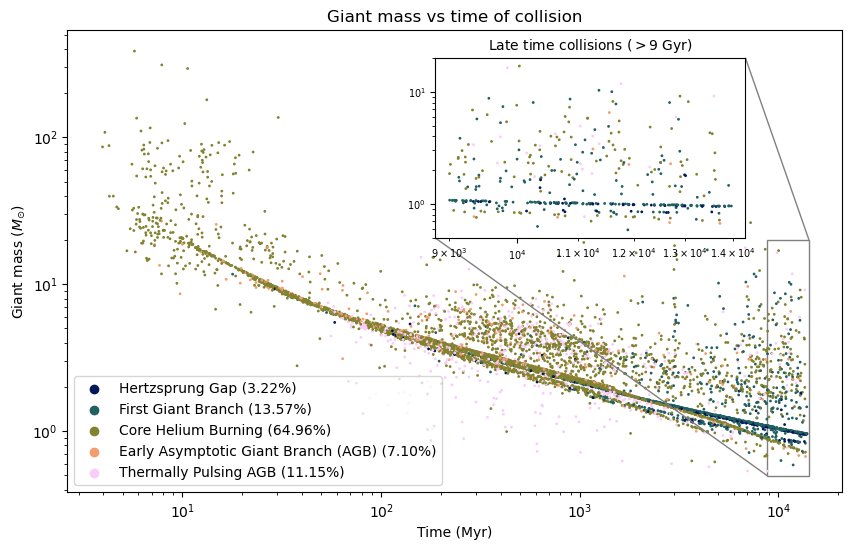

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_all, delimiter=',', dtype=str, skiprows=1)

mass_BH = data[::, 9].astype(float)
mass_Giant = data[::, 11].astype(float)
type_Giant = data[::, 19].astype(float)
times_GiantBH = data[::, 4].astype(float)

colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions_old = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]


# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}


# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]

fig, ax1 = plt.subplots(figsize=(10, 6))
# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.475,0.55,0.4,0.39])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=3, loc2=1, fc="none", ec='0.5')



scatter = ax1.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax1.set_xlabel(r'Time (Myr)')
ax1.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax1.set_title('Giant mass vs time of collision')
ax1.set_xscale('log')
ax1.set_yscale('log')
print(len(times_GiantBH))
# Create a legend
legend_labels = {N: f'{N} ({frac:.2f}%)' for N,frac in zip(giant_name_types, fractions_old)}
legend_handles = []
for N,n in zip(giant_name_types, unique_numbers):
    label = legend_labels[N]
    color = N_to_color[n]
    legend_handles.append(ax1.scatter([], [], c=color, label=label))
ax1.legend(handles=legend_handles, loc='lower left')


# Check time
check_t = np.array(data[:, 4], dtype=float) > 9e3
data_t = data[check_t]
mass_Giant = data_t[::, 11].astype(float)
type_Giant = data_t[::, 19].astype(float)
times_GiantBH = data_t[::, 4].astype(float)



colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]


ax2.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Late time collisions ($>9$ Gyr)', fontsize=10)
ax2.tick_params(axis='both', which='both', labelsize=7)


#plt.savefig('William_Yang_Giant_mass_collision_time.png', dpi=500)

C:\Users\willi\AppData\Local\Temp\ipykernel_36972\121837635.py:54: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax1, [0.475,0.55,0.4,0.39])
C:\Users\willi\AppData\Local\Temp\ipykernel_36972\121837635.py:75: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax1.scatter([], [], c=color, label=label))


4754


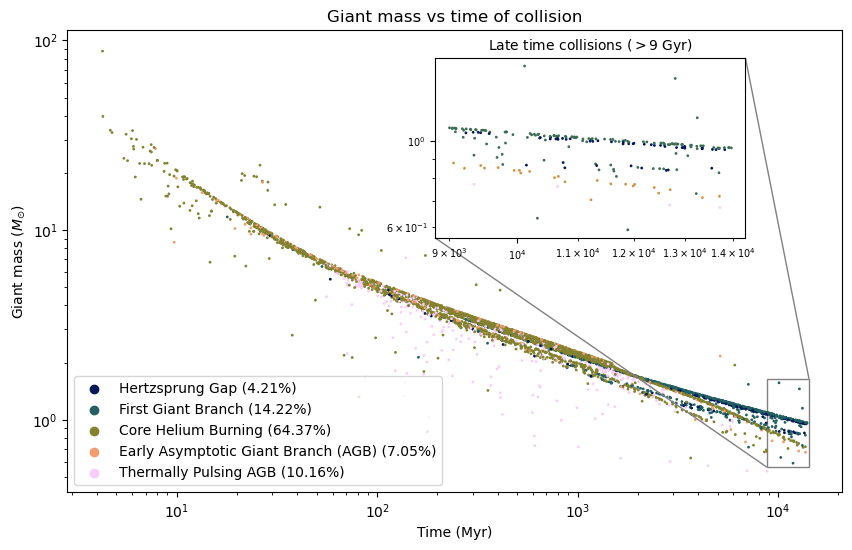

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)

mass_BH = data[::, 9].astype(float)
mass_Giant = data[::, 11].astype(float)
type_Giant = data[::, 19].astype(float)
times_GiantBH = data[::, 4].astype(float)

colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions_old = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]


# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}


# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]

fig, ax1 = plt.subplots(figsize=(10, 6))
# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.475,0.55,0.4,0.39])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=3, loc2=1, fc="none", ec='0.5')



scatter = ax1.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax1.set_xlabel(r'Time (Myr)')
ax1.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax1.set_title('Giant mass vs time of collision')
ax1.set_xscale('log')
ax1.set_yscale('log')
print(len(times_GiantBH))
# Create a legend
legend_labels = {N: f'{N} ({frac:.2f}%)' for N,frac in zip(giant_name_types, fractions_old)}
legend_handles = []
for N,n in zip(giant_name_types, unique_numbers):
    label = legend_labels[N]
    color = N_to_color[n]
    legend_handles.append(ax1.scatter([], [], c=color, label=label))
ax1.legend(handles=legend_handles, loc='lower left')


# Check time
check_t = np.array(data[:, 4], dtype=float) > 9e3
data_t = data[check_t]
mass_Giant = data_t[::, 11].astype(float)
type_Giant = data_t[::, 19].astype(float)
times_GiantBH = data_t[::, 4].astype(float)



colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]


ax2.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Late time collisions ($>9$ Gyr)', fontsize=10)
ax2.tick_params(axis='both', which='both', labelsize=7)


#plt.savefig('William_Yang_Giant_mass_collision_time.png', dpi=500)

C:\Users\willi\AppData\Local\Temp\ipykernel_36972\3628121540.py:56: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax1, [0.535,0.50,0.4,0.4])
C:\Users\willi\AppData\Local\Temp\ipykernel_36972\3628121540.py:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax1.scatter([], [], c=color, label=label))


Text(0.5, 1.0, 'Late time collisions ($>9$ Gyr)')

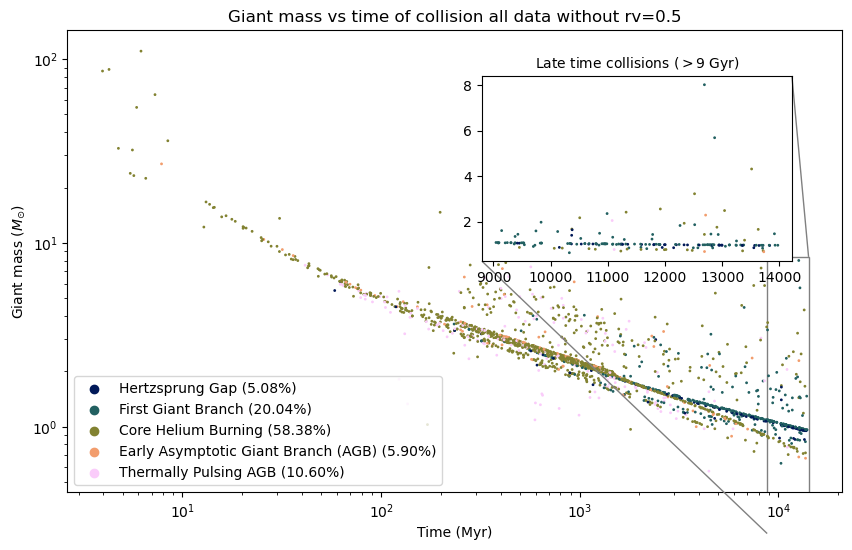

In [12]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_all, delimiter=',', dtype=str, skiprows=1)

# Check rv
check_rv = np.array(data[:, 1], dtype=float) != 0.5
data_rv = data[check_rv]

mass_BH = data_rv[::, 9].astype(float)
mass_Giant = data_rv[::, 11].astype(float)
type_Giant = data_rv[::, 19].astype(float)
times_GiantBH = data_rv[::, 4].astype(float)

colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions_old = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]


# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}


# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]

fig, ax1 = plt.subplots(figsize=(10, 6))
# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.535,0.50,0.4,0.4])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=3, loc2=1, fc="none", ec='0.5')



scatter = ax1.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax1.set_xlabel(r'Time (Myr)')
ax1.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax1.set_title('Giant mass vs time of collision all data without rv=0.5')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Create a legend
legend_labels = {N: f'{N} ({frac:.2f}%)' for N,frac in zip(giant_name_types, fractions_old)}
legend_handles = []
for N,n in zip(giant_name_types, unique_numbers):
    label = legend_labels[N]
    color = N_to_color[n]
    legend_handles.append(ax1.scatter([], [], c=color, label=label))
ax1.legend(handles=legend_handles, loc='lower left')


# Check time
check_t = np.array(data_rv[:, 4], dtype=float) > 9e3
data_t = data_rv[check_t]
mass_Giant = data_t[::, 11].astype(float)
type_Giant = data_t[::, 19].astype(float)
times_GiantBH = data_t[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]


ax2.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax2.set_title('Late time collisions ($>9$ Gyr)', fontsize=10)



C:\Users\willi\AppData\Local\Temp\ipykernel_36972\4101636999.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


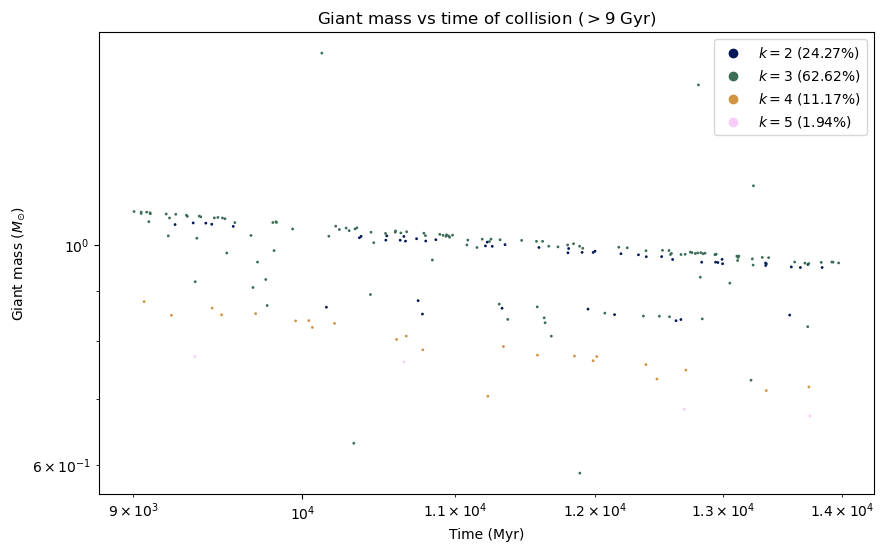

In [13]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)

# Check time
check_t = np.array(data[:, 4], dtype=float) > 9e3
data_t = data[check_t]

mass_BH = data_t[::, 9].astype(float)
mass_Giant = data_t[::, 11].astype(float)
type_Giant = data_t[::, 19].astype(float)
times_GiantBH = data_t[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions_old = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs time of collision ($>9$ Gyr)')
ax.set_xscale('log')
ax.set_yscale('log')

# Create a legend
legend_labels = {N: rf'$k={int(N)}$ ({frac:.2f}%)' for N,frac in zip(unique_numbers, fractions_old)}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[N]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
ax.legend(handles=legend_handles, loc='best')




C:\Users\willi\AppData\Local\Temp\ipykernel_36972\206777814.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


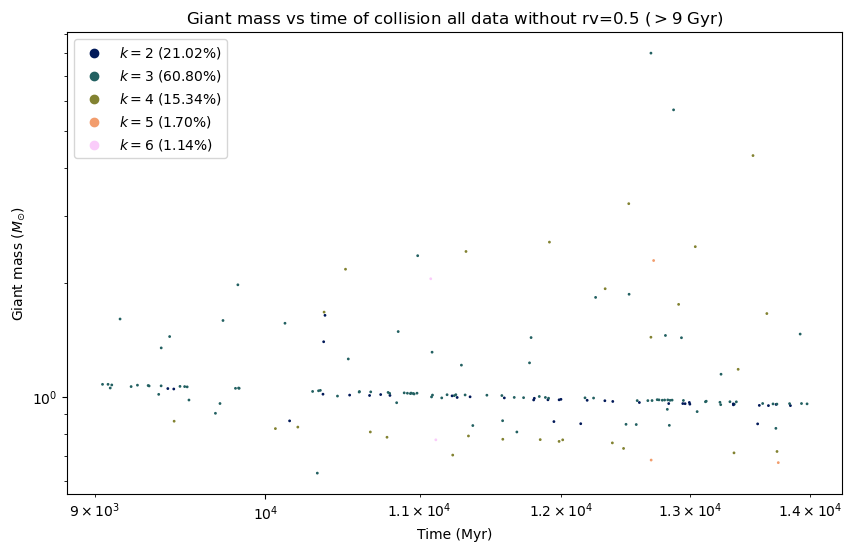

In [14]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_all, delimiter=',', dtype=str, skiprows=1)

# Check time
check_t = np.array(data[:, 4], dtype=float) > 9e3
data_t = data[check_t]

# Check rv
check_rv = np.array(data_t[:, 1], dtype=float) != 0.5
data_rv = data_t[check_rv]


mass_BH = data_rv[::, 9].astype(float)
mass_Giant = data_rv[::, 11].astype(float)
type_Giant = data_rv[::, 19].astype(float)
times_GiantBH = data_rv[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions_old = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs time of collision all data without rv=0.5 ($>9$ Gyr)')
ax.set_xscale('log')
ax.set_yscale('log')

# Create a legend
legend_labels = {N: rf'$k={int(N)}$ ({frac:.2f}%)' for N,frac in zip(unique_numbers, fractions_old)}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[N]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
ax.legend(handles=legend_handles, loc='best')




C:\Users\willi\AppData\Local\Temp\ipykernel_36972\657130100.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


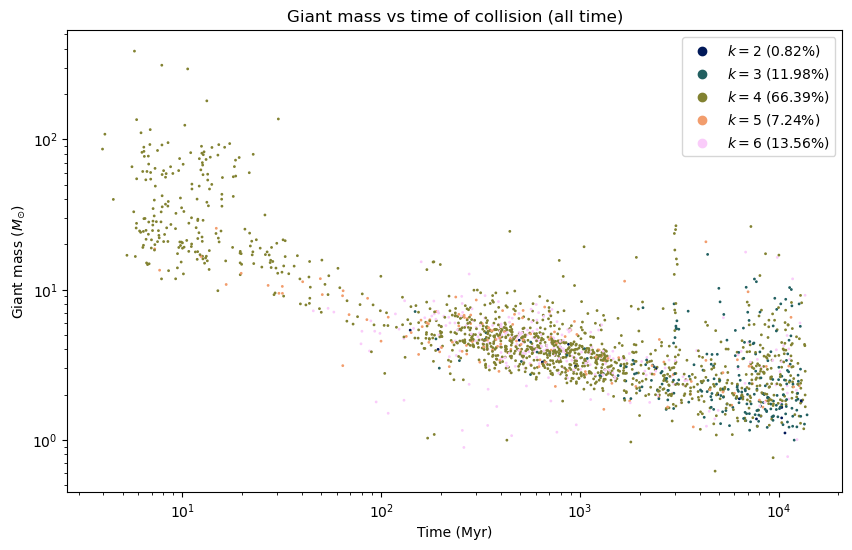

In [15]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_iscollision, delimiter=',', dtype=str, skiprows=1)

mass_BH = data[::, 9].astype(float)
mass_Giant = data[::, 11].astype(float)
type_Giant = data[::, 19].astype(float)
times_GiantBH = data[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions_old = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(times_GiantBH, mass_Giant, s=1, color=colors_N)
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs time of collision (all time)')
ax.set_xscale('log')
ax.set_yscale('log')

# Create a legend
legend_labels = {N: rf'$k={int(N)}$ ({frac:.2f}%)' for N,frac in zip(unique_numbers, fractions_old)}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[N]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
ax.legend(handles=legend_handles, loc='best')


In [16]:
# Load the CSV file into a numpy array
data_iscollision = np.loadtxt(output_file_iscollision, delimiter=',', dtype=str, skiprows=1)
data_nocollision = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)
data_all = np.loadtxt(output_file_all, delimiter=',', dtype=str, skiprows=1)

frac_iscollision = len(data_iscollision)/len(data_all)

frac_nocollision = len(data_nocollision)/len(data_all)

print(f"The fraction that are merger products is: {frac_iscollision:.2f}")
print(f"The fraction that are not merger products is: {frac_nocollision:.2f}")


# Check age
check_old = np.array(data_iscollision[:, 4], dtype=float) > 9e3
data_iscollision_old = data_iscollision[check_old]

check_old = np.array(data_nocollision[:, 4], dtype=float) > 9e3
data_nocollision_old = data_nocollision[check_old]

check_old = np.array(data_all[:, 4], dtype=float) > 9e3
data_all_old = data_all[check_old]

frac_iscollision_old = len(data_iscollision_old)/len(data_all_old)

frac_nocollision_old = len(data_nocollision_old)/len(data_all_old)

print(f"The fraction that are old merger products is: {frac_iscollision_old:.2f}")
print(f"The fraction that are old not merger products is: {frac_nocollision_old:.2f}")


The fraction that are merger products is: 0.29
The fraction that are not merger products is: 0.71
The fraction that are old merger products is: 0.47
The fraction that are old not merger products is: 0.53


In [17]:
print(len(data_iscollision))
print(len(data_nocollision))
print(len(data_all))
print(len(data_iscollision_old))
print(len(data_nocollision_old))
print(len(data_all_old))

1961
4754
6715
181
206
387


In [18]:
# Load the CSV file into a numpy array
data_iscollision = np.loadtxt(output_file_iscollision, delimiter=',', dtype=str, skiprows=1)
data_nocollision = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)
data_all = np.loadtxt(output_file_all, delimiter=',', dtype=str, skiprows=1)


# Check rv
check_rv = np.array(data_iscollision[:, 1], dtype=float) != 0.5
data_iscollision = data_iscollision[check_rv]

check_rv = np.array(data_nocollision[:, 1], dtype=float) != 0.5
data_nocollision = data_nocollision[check_rv]

check_rv = np.array(data_all[:, 1], dtype=float) != 0.5
data_all = data_all[check_rv]


frac_iscollision = len(data_iscollision)/len(data_all)

frac_nocollision = len(data_nocollision)/len(data_all)

print(f"The fraction that are merger products is: {frac_iscollision:.2f}")
print(f"The fraction that are not merger products is: {frac_nocollision:.2f}")


# Check age
check_old = np.array(data_iscollision[:, 4], dtype=float) > 9e3
data_iscollision_old = data_iscollision[check_old]

check_old = np.array(data_nocollision[:, 4], dtype=float) > 9e3
data_nocollision_old = data_nocollision[check_old]

check_old = np.array(data_all[:, 4], dtype=float) > 9e3
data_all_old = data_all[check_old]

frac_iscollision_old = len(data_iscollision_old)/len(data_all_old)

frac_nocollision_old = len(data_nocollision_old)/len(data_all_old)

print(f"The fraction that are old merger products is: {frac_iscollision_old:.2f}")
print(f"The fraction that are old not merger products is: {frac_nocollision_old:.2f}")


The fraction that are merger products is: 0.18
The fraction that are not merger products is: 0.82
The fraction that are old merger products is: 0.20
The fraction that are old not merger products is: 0.80


In [19]:
print(len(data_iscollision))
print(len(data_nocollision))
print(len(data_all))
print(len(data_iscollision_old))
print(len(data_nocollision_old))
print(len(data_all_old))

332
1499
1831
35
141
176


In [20]:
def normalize(numbers):
    min_val = min(numbers)
    max_val = max(numbers)
    
    if min_val == max_val:
        # Avoid division by zero if all numbers in the list are the same
        return [0.5 for _ in numbers]
    
    normalized_numbers = [(num) / (np.sum(numbers)) for num in numbers]
    return normalized_numbers

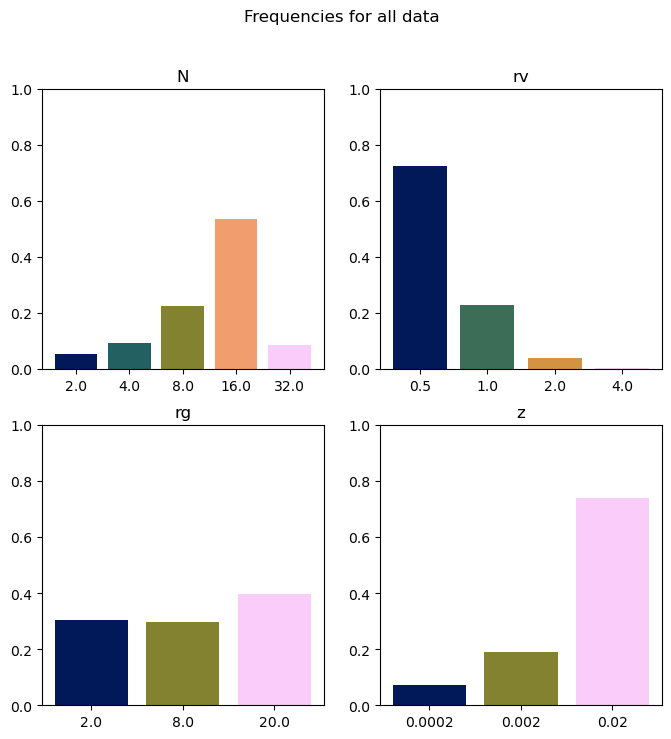

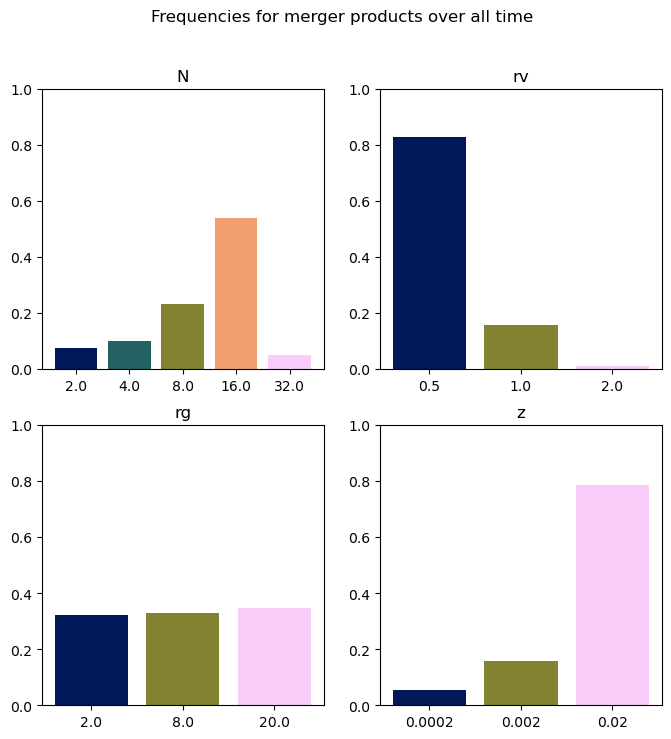

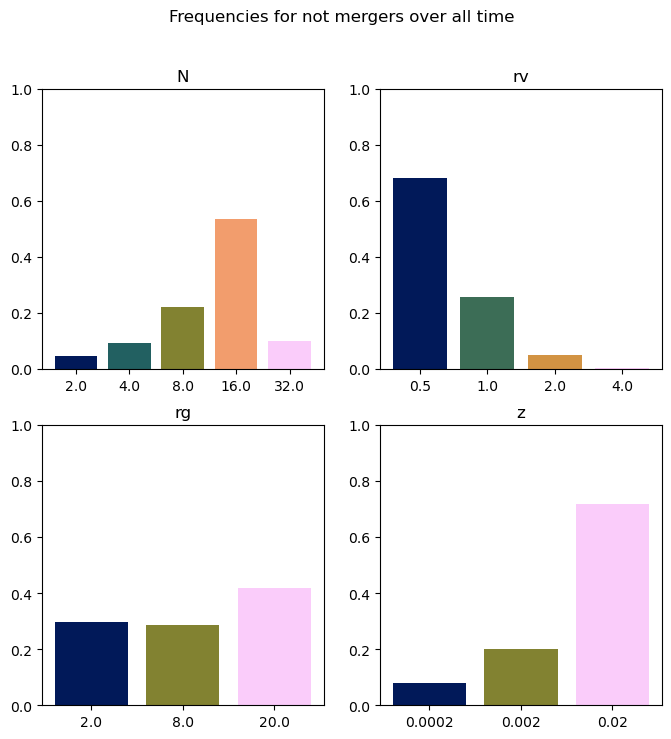

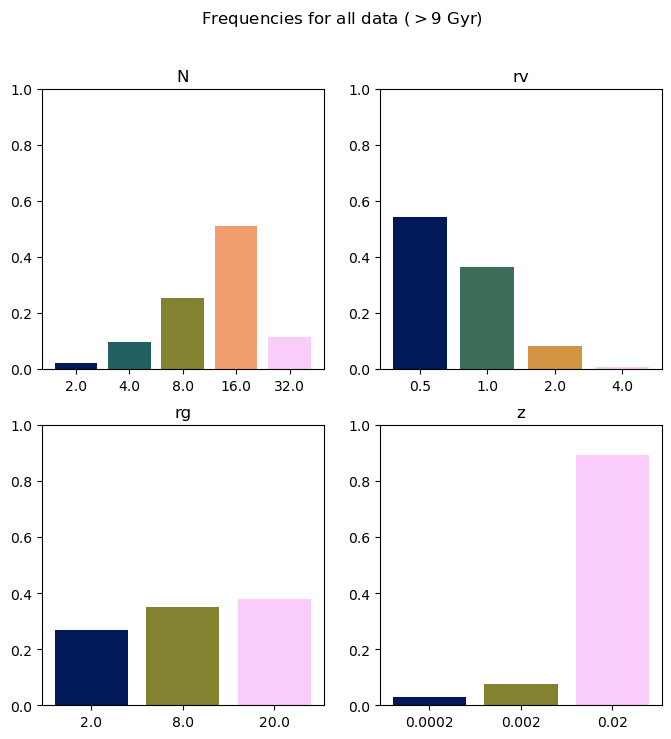

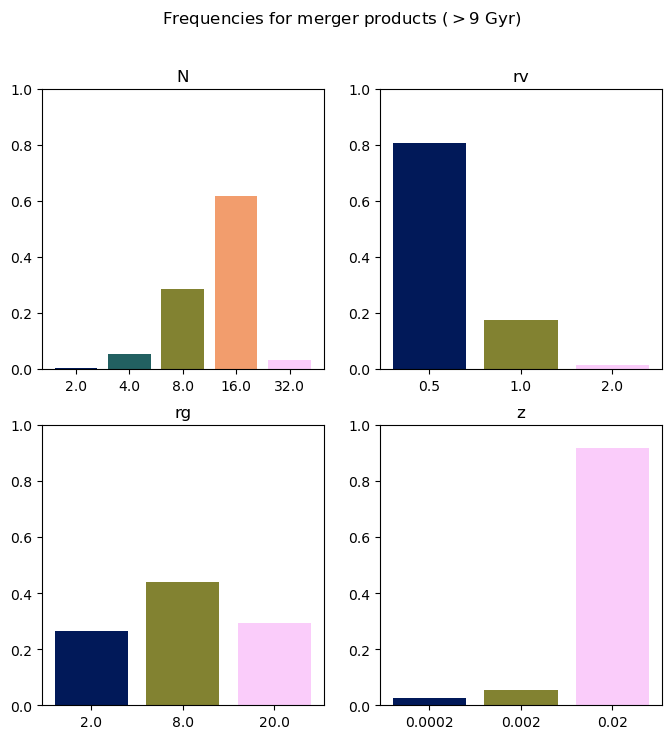

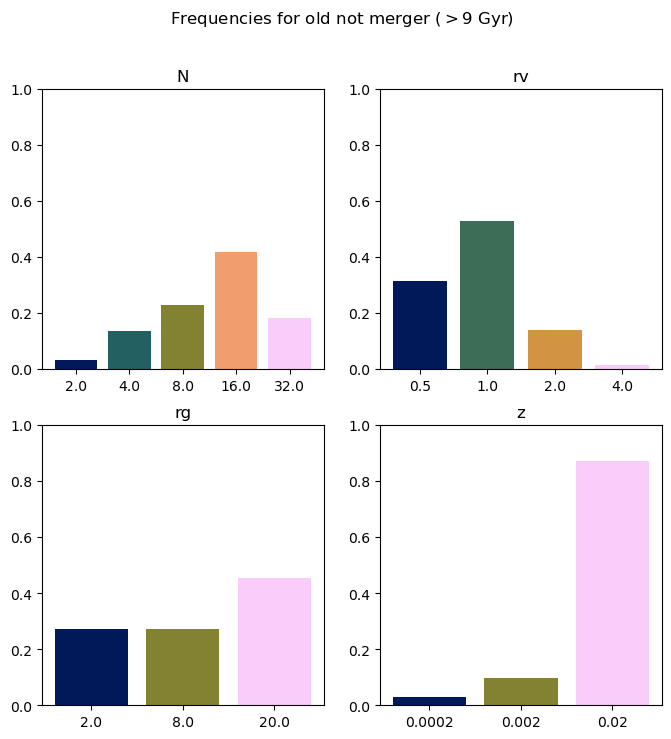

In [21]:
# Load the CSV file into a numpy array
data_iscollision = np.loadtxt(output_file_iscollision, delimiter=',', dtype=str, skiprows=1)
data_nocollision = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)
data_all = np.loadtxt(output_file_all, delimiter=',', dtype=str, skiprows=1)

# Check age
check_old = np.array(data_iscollision[:, 4], dtype=float) > 9e3
data_iscollision_old = data_iscollision[check_old]
check_old = np.array(data_nocollision[:, 4], dtype=float) > 9e3
data_nocollision_old = data_nocollision[check_old]
check_old = np.array(data_all[:, 4], dtype=float) > 9e3
data_all_old = data_all[check_old]



datasets = [data_all, data_iscollision, data_nocollision, data_all_old, data_iscollision_old, data_nocollision_old]
titles = ["all data", "merger products over all time", "not mergers over all time", "all data ($>9$ Gyr)", "merger products ($>9$ Gyr)", "old not merger ($>9$ Gyr)"]

for dataset, title in zip(datasets, titles):
    Ns = dataset[::, 0].astype(float)
    rvs = dataset[::, 1].astype(float)
    rgs = dataset[::, 2].astype(float)
    zs = dataset[::, 3].astype(float)

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))


    unique, counts = np.unique(Ns, return_counts=True)

    combined = list(zip(unique, counts))
    sorted_combined = sorted(combined)
    sorted_unique, sorted_counts = zip(*sorted_combined)
    sorted_unique = list(sorted_unique)
    sorted_counts = list(sorted_counts)
    normalized_counts = normalize(sorted_counts)

    colors = cm.batlow(np.linspace(0, 1, len(sorted_unique)))
    ax[0, 0].bar(np.array(sorted_unique).astype(str), normalized_counts, color=colors)

    ax[0, 0].set_title('N')
    ax[0, 0].set_ylim(0, 1)


    unique, counts = np.unique(rvs, return_counts=True)

    combined = list(zip(unique, counts))
    sorted_combined = sorted(combined)
    sorted_unique, sorted_counts = zip(*sorted_combined)
    sorted_unique = list(sorted_unique)
    sorted_counts = list(sorted_counts)
    normalized_counts = normalize(sorted_counts)

    colors = cm.batlow(np.linspace(0, 1, len(sorted_unique)))
    ax[0, 1].bar(np.array(sorted_unique).astype(str), normalized_counts, color=colors)

    ax[0, 1].set_title('rv')
    ax[0, 1].set_ylim(0, 1)


    unique, counts = np.unique(rgs, return_counts=True)
    
    combined = list(zip(unique, counts))
    sorted_combined = sorted(combined)
    sorted_unique, sorted_counts = zip(*sorted_combined)
    sorted_unique = list(sorted_unique)
    sorted_counts = list(sorted_counts)
    normalized_counts = normalize(sorted_counts)
    
    colors = cm.batlow(np.linspace(0, 1, len(sorted_unique)))
    ax[1, 0].bar(np.array(sorted_unique).astype(str), normalized_counts, color=colors)
    
    ax[1, 0].set_title('rg')
    ax[1, 0].set_ylim(0, 1)


    unique, counts = np.unique(zs, return_counts=True)

    combined = list(zip(unique, counts))
    sorted_combined = sorted(combined)
    sorted_unique, sorted_counts = zip(*sorted_combined)
    sorted_unique = list(sorted_unique)
    sorted_counts = list(sorted_counts)
    normalized_counts = normalize(sorted_counts)
    
    colors = cm.batlow(np.linspace(0, 1, len(sorted_unique)))
    ax[1, 1].bar(np.array(sorted_unique).astype(str), normalized_counts, color=colors)

    ax[1, 1].set_title('z')
    ax[1, 1].set_ylim(0, 1)

    fig.suptitle(f"Frequencies for {title}")


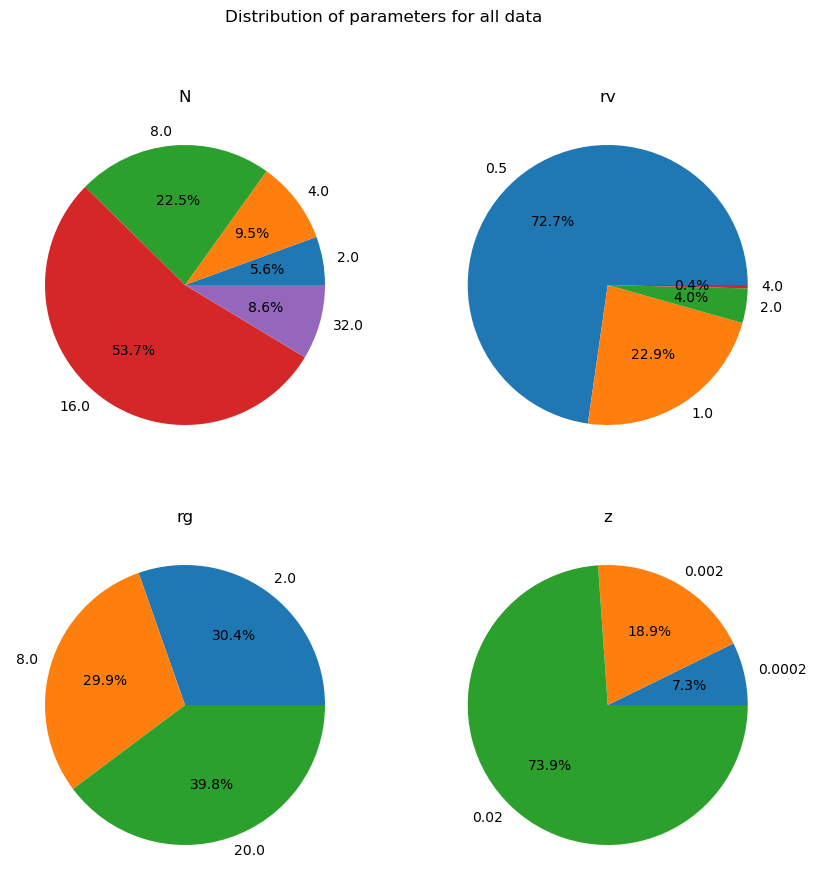

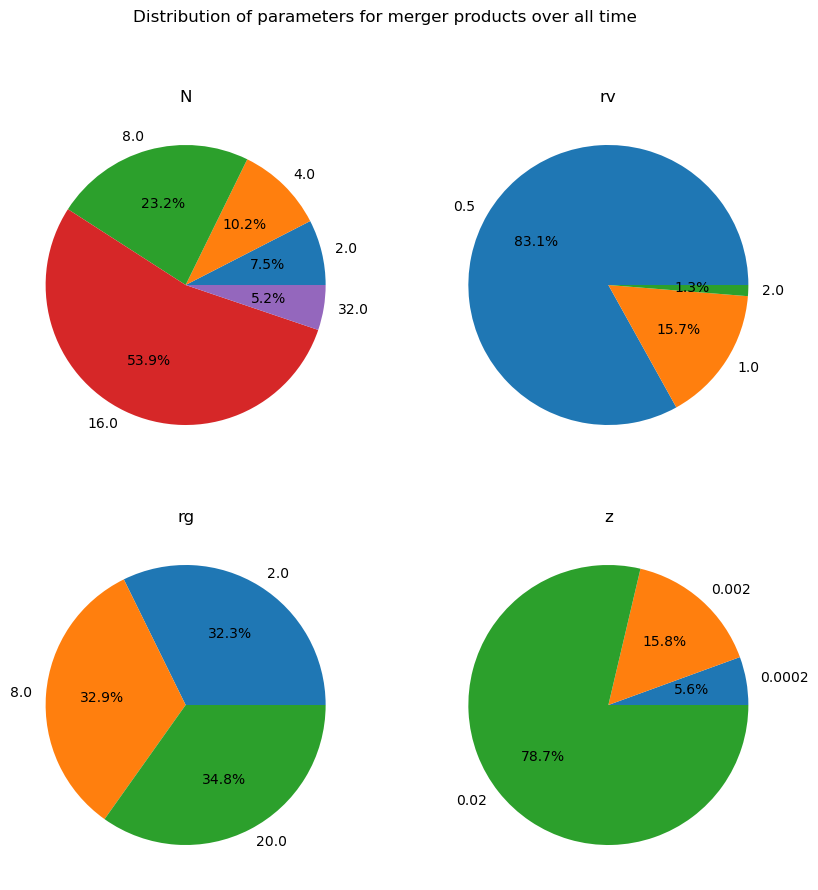

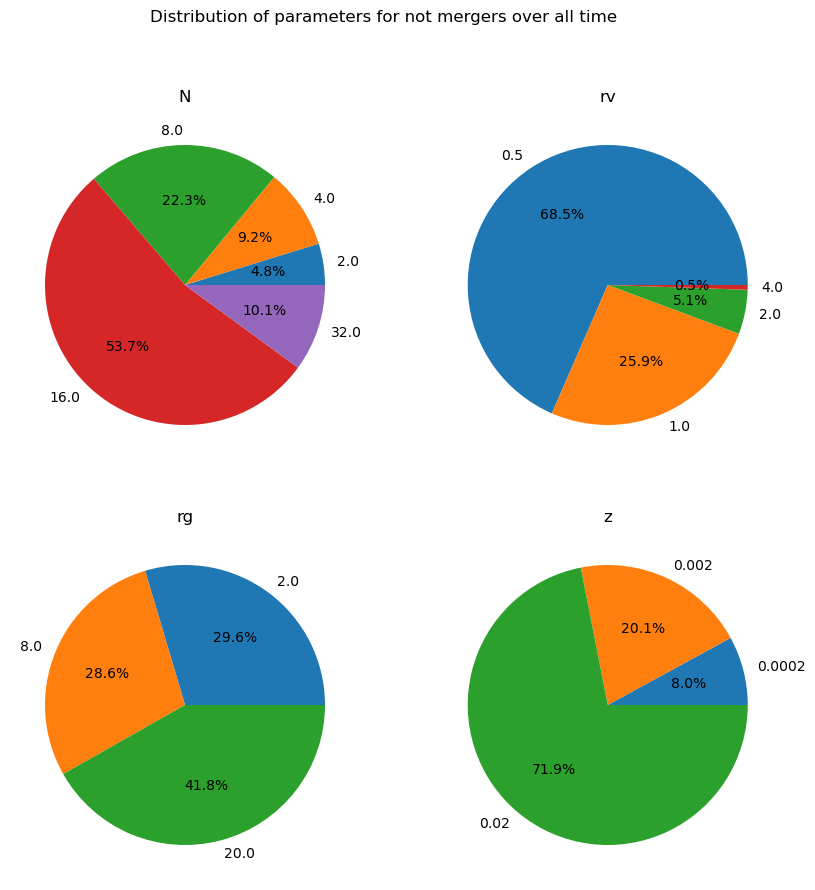

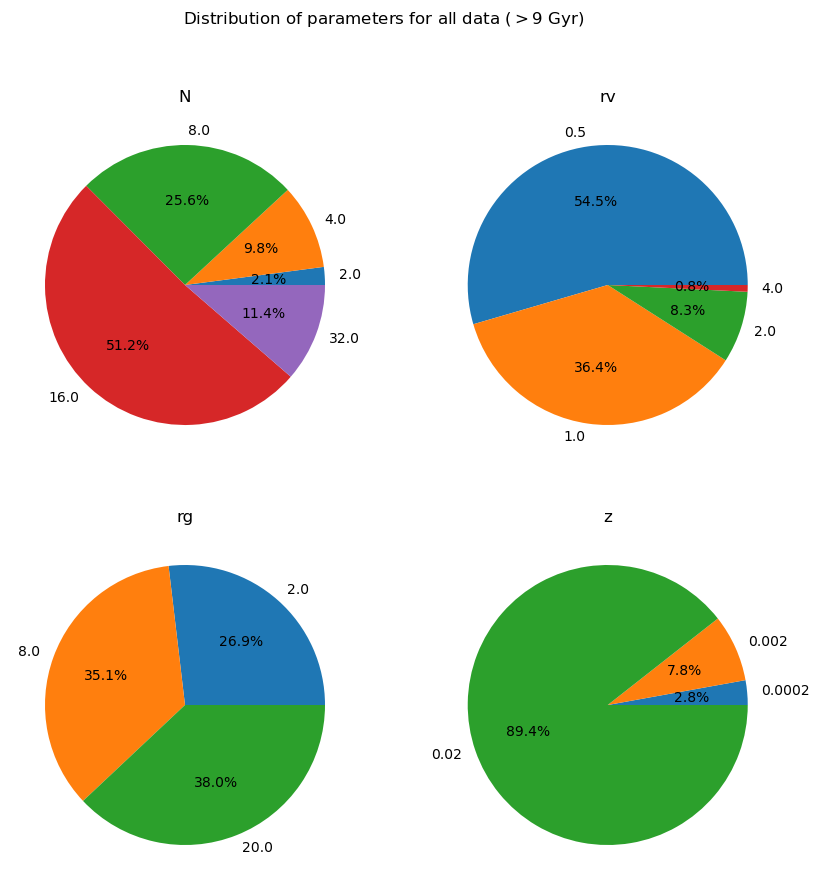

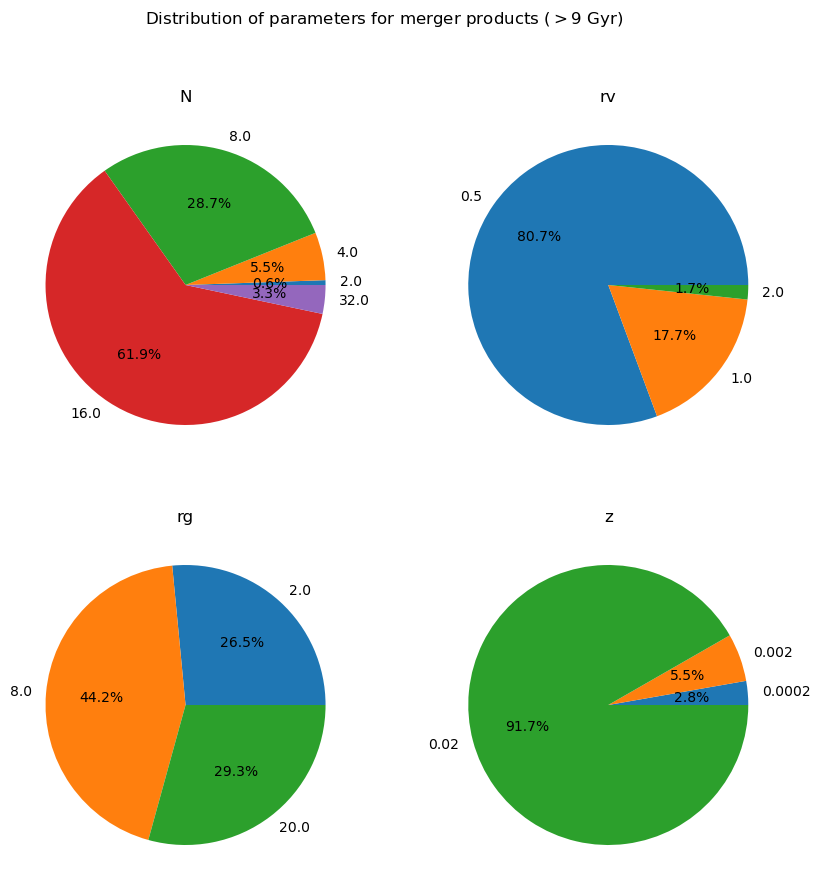

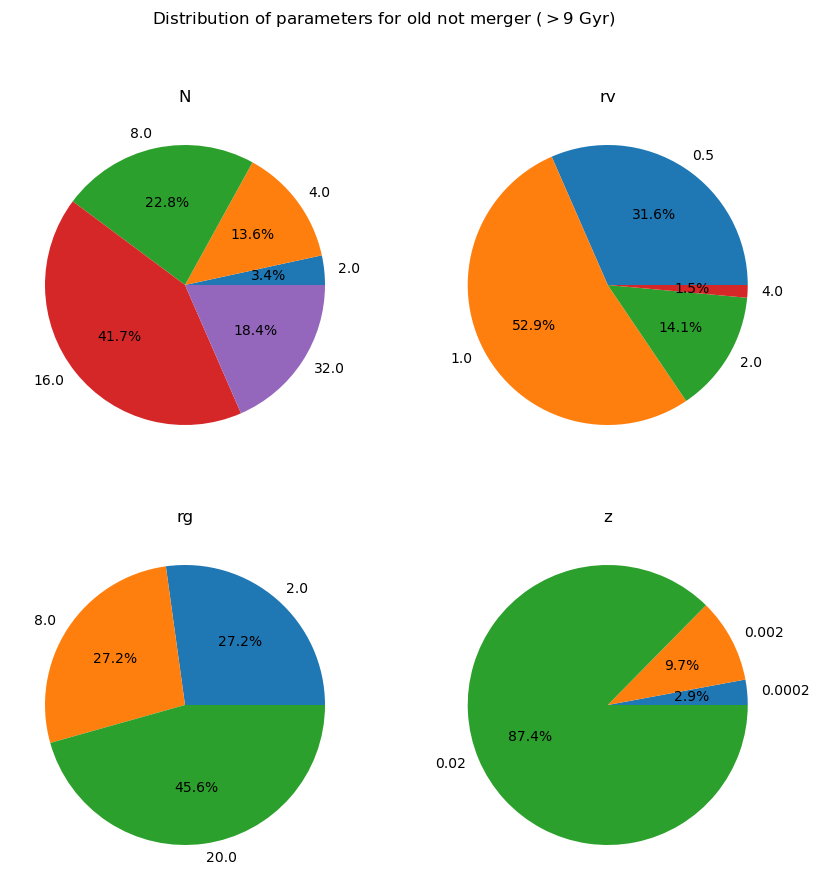

In [22]:

datasets = [data_all, data_iscollision, data_nocollision, data_all_old, data_iscollision_old, data_nocollision_old]
titles = ["all data", "merger products over all time", "not mergers over all time", "all data ($>9$ Gyr)", "merger products ($>9$ Gyr)", "old not merger ($>9$ Gyr)"]

for dataset, title in zip(datasets, titles):
    Ns = dataset[::, 0].astype(float)
    rvs = dataset[::, 1].astype(float)
    rgs = dataset[::, 2].astype(float)
    zs = dataset[::, 3].astype(float)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    #ax[0, 0].hist(Ns, bins=20, color='b', alpha=0.7)
    unique, counts = np.unique(Ns, return_counts=True)
    ax[0, 0].pie(counts, labels=unique, autopct='%1.1f%%')
    ax[0, 0].set_title('N')

    #ax[0, 1].hist(rvs, bins=20, color='b', alpha=0.7)
    unique, counts = np.unique(rvs, return_counts=True)
    ax[0, 1].pie(counts, labels=unique, autopct='%1.1f%%')
    ax[0, 1].set_title('rv')

    #ax[1, 0].hist(rgs, bins=20, color='b', alpha=0.7)
    unique, counts = np.unique(rgs, return_counts=True)
    ax[1, 0].pie(counts, labels=unique, autopct='%1.1f%%')
    ax[1, 0].set_title('rg')

    #ax[1, 1].hist(zs, bins=20, color='b', alpha=0.7)
    unique, counts = np.unique(zs, return_counts=True)
    ax[1, 1].pie(counts, labels=unique, autopct='%1.1f%%')
    ax[1, 1].set_title('z')

    fig.suptitle(f"Distribution of parameters for {title}")


C:\Users\willi\AppData\Local\Temp\ipykernel_36972\1843626853.py:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


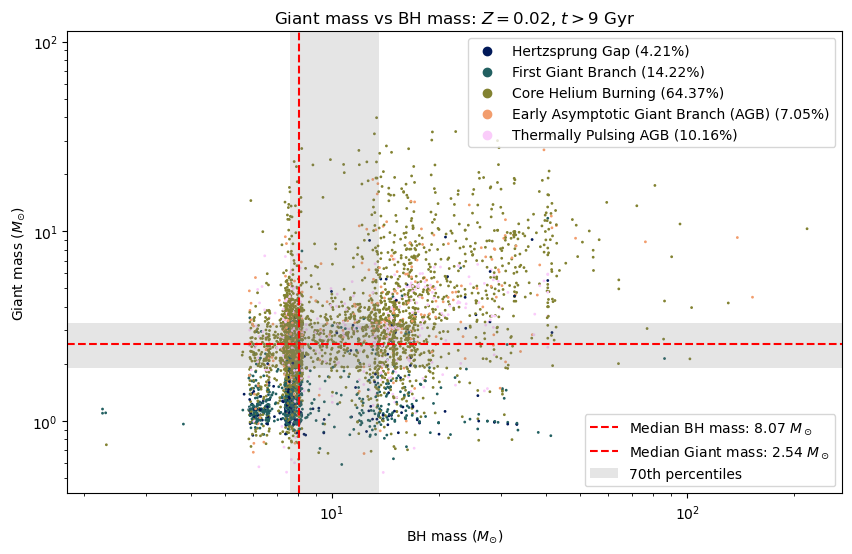

In [63]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)


mass_BH = data[::, 9].astype(float)

mass_Giant = data[::, 11].astype(float)
type_Giant = data[::, 19].astype(float)
times_GiantBH = data[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(mass_BH, mass_Giant, s=1, color=colors_N)

median_BH = np.median(mass_BH)
median_Giant = np.median(mass_Giant)
median_BH_line = ax.axvline(median_BH, color='red', linestyle='--', label=rf'Median BH mass: {median_BH:.2f} $M_\odot$')
median_Giant_line = ax.axhline(median_Giant, color='red', linestyle='--', label=rf'Median Giant mass: {median_Giant:.2f} $M_\odot$')

mass_Giant_30 = np.percentile(mass_Giant, 30)
mass_Giant_70 = np.percentile(mass_Giant, 70)
mass_BH_30 = np.percentile(mass_BH, 30)
mass_BH_70 = np.percentile(mass_BH, 70)

percentiles = ax.axhspan(mass_Giant_30, mass_Giant_70, color='gray', alpha=0.2, lw=0, label="70th percentiles")
ax.axvspan(mass_BH_30, mass_BH_70, color='gray', alpha=0.2, lw=0)

ax.set_xlabel(r'BH mass ($M_{\odot}$)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs BH mass: $Z=0.02$, $t>9$ Gyr')
ax.set_xscale('log')
ax.set_yscale('log')

# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}

# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]

# Create a legend
legend_labels = {stage_mapping[N]: f'{stage_mapping[N]} ({frac:.2f}%)' for N, frac in zip(unique_numbers, fractions)}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[stage_mapping[N]]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
first_legend = ax.legend(handles=legend_handles, loc='best')
ax.add_artist(first_legend)  # Add the first legend as an artist to the axes

# Create the second legend for the median lines
median_legend = ax.legend(handles=[median_BH_line, median_Giant_line, percentiles], loc='lower right')



43
111
22
4


C:\Users\willi\AppData\Local\Temp\ipykernel_36972\1221630960.py:89: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


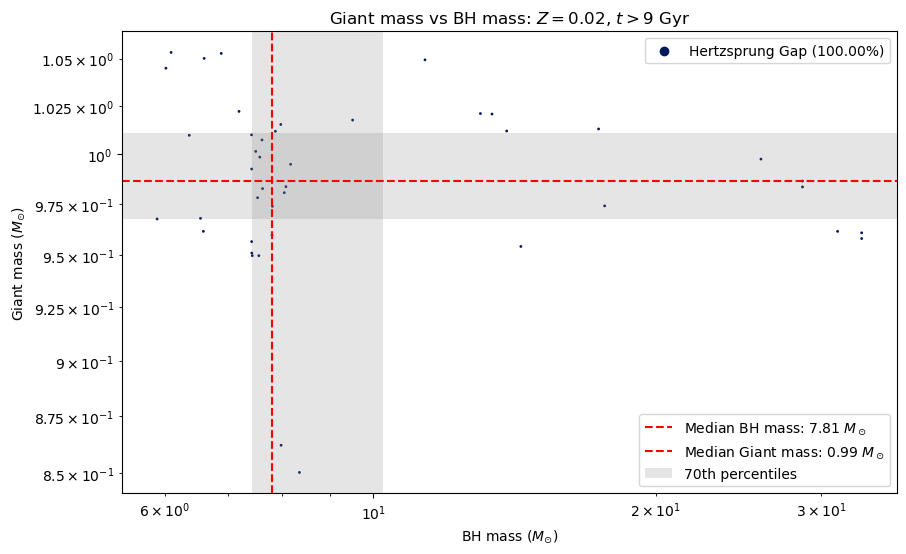

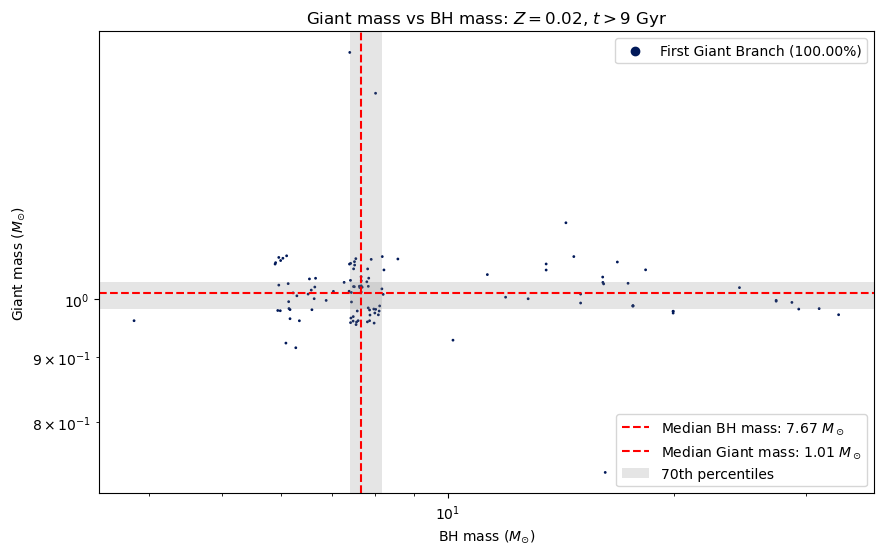

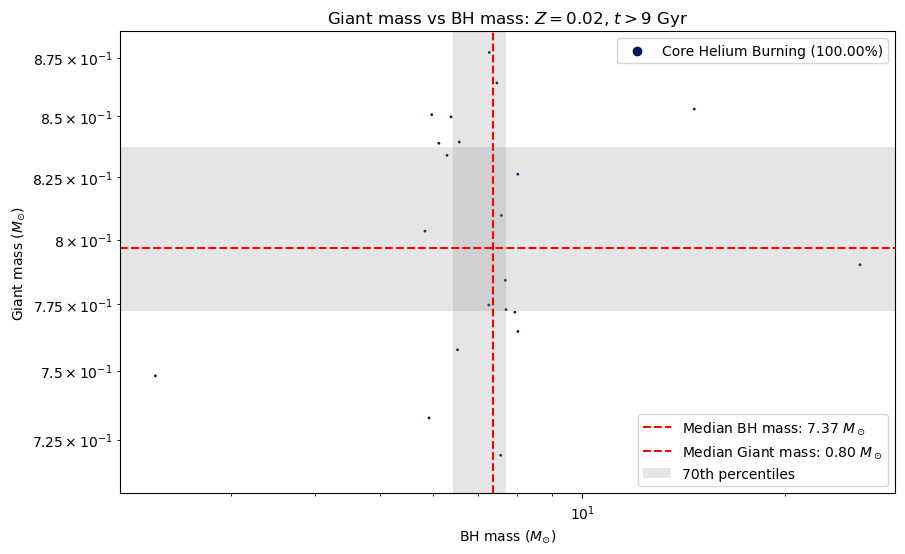

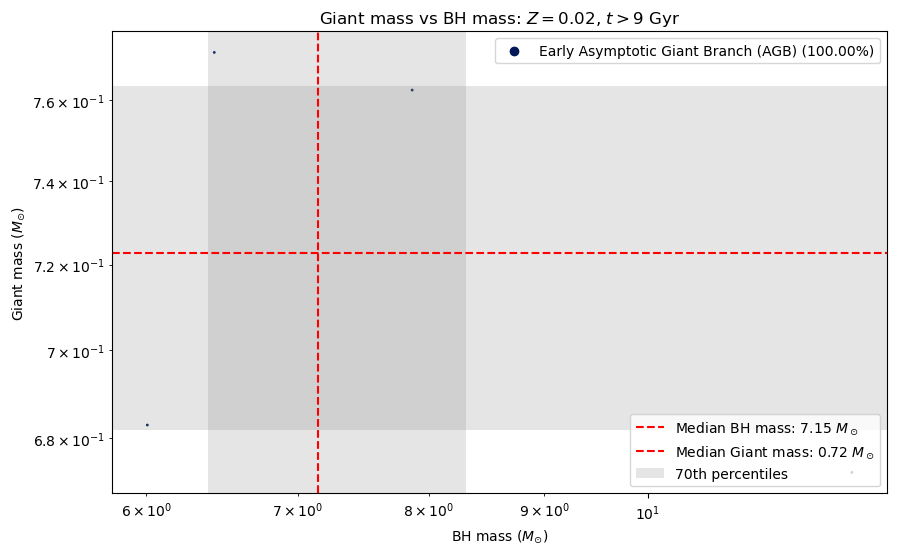

In [66]:
median_giant_masses = []
# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)
for i in range(2,6):
        
    # Check k
    check_k = np.array(data[:, 19], dtype=float) == float(i)
    data_k = data[check_k]

    # Check z
    check_z = np.array(data_k[:, 3], dtype=float) == 0.02
    data_z = data_k[check_z]

    # Check age
    check_old = np.array(data_z[:, 4], dtype=float) > 9e3
    data_old = data_z[check_old]

    mass_BH = data_old[::, 9].astype(float)
    mass_Giant = data_old[::, 11].astype(float)
    type_Giant = data_old[::, 19].astype(float)
    times_GiantBH = data_old[::, 4].astype(float)
    print(len(mass_Giant))

    colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

    # Get unique numbers from the list
    unique_numbers = list(set(type_Giant))
    unique_numbers.sort()

    # Create a mapping of unique numbers to colors
    N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
    colors_N = [N_to_color[N] for N in type_Giant]

    # Get percentages for each type
    fractions = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

    fig, ax = plt.subplots(figsize=(10, 6))

    scatter = ax.scatter(mass_BH, mass_Giant, s=1, color=colors_N)

    median_BH = np.median(mass_BH)
    median_Giant = np.median(mass_Giant)
    median_BH_line = ax.axvline(median_BH, color='red', linestyle='--', label=rf'Median BH mass: {median_BH:.2f} $M_\odot$')
    median_Giant_line = ax.axhline(median_Giant, color='red', linestyle='--', label=rf'Median Giant mass: {median_Giant:.2f} $M_\odot$')

    mass_Giant_30 = np.percentile(mass_Giant, 30)
    mass_Giant_70 = np.percentile(mass_Giant, 70)
    mass_BH_30 = np.percentile(mass_BH, 30)
    mass_BH_70 = np.percentile(mass_BH, 70)

    percentiles = ax.axhspan(mass_Giant_30, mass_Giant_70, color='gray', alpha=0.2, lw=0, label="70th percentiles")
    ax.axvspan(mass_BH_30, mass_BH_70, color='gray', alpha=0.2, lw=0)

    ax.set_xlabel(r'BH mass ($M_{\odot}$)')
    ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
    ax.set_title('Giant mass vs BH mass: $Z=0.02$, $t>9$ Gyr')
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Define the dictionary for the mapping
    stage_mapping = {
        0: "Main Sequence (MS), $< 0.7 M_\odot$",
        1: "MS, $> 0.7 M_\odot$",
        2: "Hertzsprung Gap",
        3: "First Giant Branch",
        4: "Core Helium Burning",
        5: "Early Asymptotic Giant Branch (AGB)",
        6: "Thermally Pulsing AGB",
        7: "Naked Helium Star MS",
        8: "Naked Helium Star Hertzsprung Gap",
        9: "Naked Helium Star Giant Branch",
        10: "Helium White Dwarf",
        11: "Carbon/Oxygen White Dwarf",
        12: "Oxygen/Neon White Dwarf",
        13: "Neutron Star",
        14: "Black Hole",
        15: "Massless Remnant"
    }

    # Replace integers with corresponding text
    giant_name_types = [stage_mapping[num] for num in unique_numbers]

    # Create a legend
    legend_labels = {stage_mapping[N]: f'{stage_mapping[N]} ({frac:.2f}%)' for N, frac in zip(unique_numbers, fractions)}
    legend_handles = []
    for N in unique_numbers:
        label = legend_labels[stage_mapping[N]]
        color = N_to_color[N]
        legend_handles.append(ax.scatter([], [], c=color, label=label))
    first_legend = ax.legend(handles=legend_handles, loc='best')
    ax.add_artist(first_legend)  # Add the first legend as an artist to the axes

    # Create the second legend for the median lines
    median_legend = ax.legend(handles=[median_BH_line, median_Giant_line, percentiles], loc='lower right')

    median_giant_masses.append(median_Giant)


In [68]:
print(median_giant_masses)

[0.986418, 1.01138, 0.7967625, 0.7227950000000001]


206


C:\Users\willi\AppData\Local\Temp\ipykernel_36972\3741116078.py:79: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


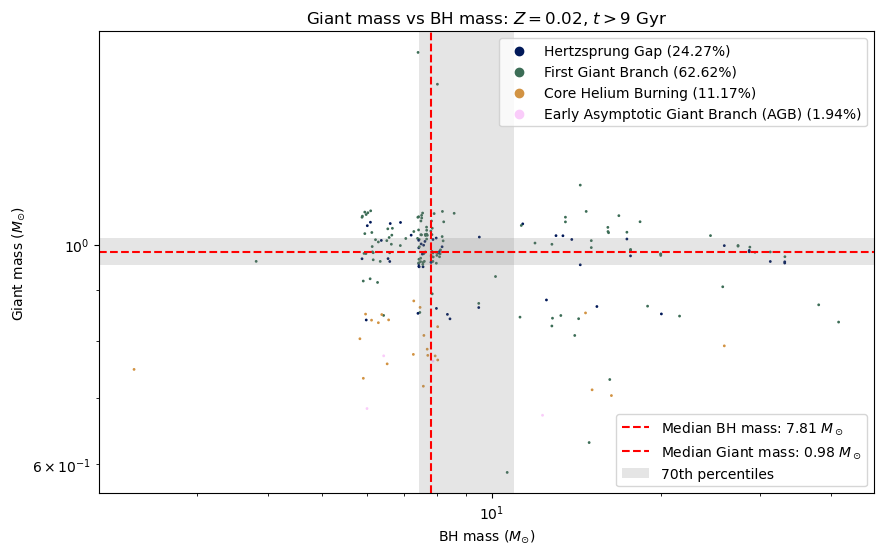

In [53]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)

# Check age
check_old = np.array(data[:, 4], dtype=float) > 9e3
data_old = data[check_old]

mass_BH = data_old[::, 9].astype(float)
mass_Giant = data_old[::, 11].astype(float)
type_Giant = data_old[::, 19].astype(float)
times_GiantBH = data_old[::, 4].astype(float)
print(len(mass_Giant))

colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]

# Get percentages for each type
fractions = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(mass_BH, mass_Giant, s=1, color=colors_N)

median_BH = np.median(mass_BH)
median_Giant = np.median(mass_Giant)
median_BH_line = ax.axvline(median_BH, color='red', linestyle='--', label=rf'Median BH mass: {median_BH:.2f} $M_\odot$')
median_Giant_line = ax.axhline(median_Giant, color='red', linestyle='--', label=rf'Median Giant mass: {median_Giant:.2f} $M_\odot$')

mass_Giant_30 = np.percentile(mass_Giant, 30)
mass_Giant_70 = np.percentile(mass_Giant, 70)
mass_BH_30 = np.percentile(mass_BH, 30)
mass_BH_70 = np.percentile(mass_BH, 70)

percentiles = ax.axhspan(mass_Giant_30, mass_Giant_70, color='gray', alpha=0.2, lw=0, label="70th percentiles")
ax.axvspan(mass_BH_30, mass_BH_70, color='gray', alpha=0.2, lw=0)

ax.set_xlabel(r'BH mass ($M_{\odot}$)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs BH mass: $Z=0.02$, $t>9$ Gyr')
ax.set_xscale('log')
ax.set_yscale('log')

# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}

# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]

# Create a legend
legend_labels = {stage_mapping[N]: f'{stage_mapping[N]} ({frac:.2f}%)' for N, frac in zip(unique_numbers, fractions)}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[stage_mapping[N]]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
first_legend = ax.legend(handles=legend_handles, loc='best')
ax.add_artist(first_legend)  # Add the first legend as an artist to the axes

# Create the second legend for the median lines
median_legend = ax.legend(handles=[median_BH_line, median_Giant_line, percentiles], loc='lower right')


In [25]:
# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}


# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)


type_Giant = data[::, 19].astype(float)
# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Check age
check_old = np.array(data[:, 4], dtype=float) > 9e3
data_old = data[check_old]
type_Giant_old = data_old[::, 19].astype(float)
# Get unique numbers from the list
unique_numbers_old = list(set(type_Giant_old))
unique_numbers_old.sort()


print(len(type_Giant))
print(len(type_Giant_old))



giant_types = ['$k=' + str(int(num)) + '$' for num in unique_numbers]
print(giant_types)
# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]
print(giant_name_types)
giant_types_old = ['$k=' + str(int(num)) + '$' for num in unique_numbers_old]
print(giant_types_old)
# Replace integers with corresponding text
giant_name_types_old = [stage_mapping[num] for num in unique_numbers_old]
print(giant_name_types_old)


4754
206
['$k=2$', '$k=3$', '$k=4$', '$k=5$', '$k=6$']
['Hertzsprung Gap', 'First Giant Branch', 'Core Helium Burning', 'Early Asymptotic Giant Branch (AGB)', 'Thermally Pulsing AGB']
['$k=2$', '$k=3$', '$k=4$', '$k=5$']
['Hertzsprung Gap', 'First Giant Branch', 'Core Helium Burning', 'Early Asymptotic Giant Branch (AGB)']


ValueError: 'label' must be of length 'x'

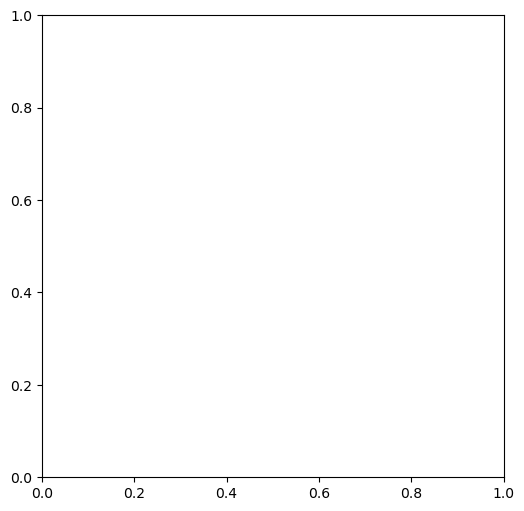

In [26]:
colors = cm.batlow(np.linspace(0, 1, 1+len(set(unique_numbers))))

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.pie(fractions, labels=giant_name_types, autopct='%1.2f%%', colors=colors)

for autotext in scatter[2]:
    autotext.set_color('white')
    
ax.set_title(r'Giant type for Giant BH collisions (all time)')
ax.legend(scatter[0], giant_types, title='Giant type', loc='center left', bbox_to_anchor=(-0.25, -0.25, 0.5, 1))

In [ ]:
print(giant_name_types_old)
print(fractions_old)

['Hertzsprung Gap', 'First Giant Branch', 'Core Helium Burning', 'Early Asymptotic Giant Branch (AGB)']
[24.271844660194176, 62.62135922330097, 11.16504854368932, 1.941747572815534]


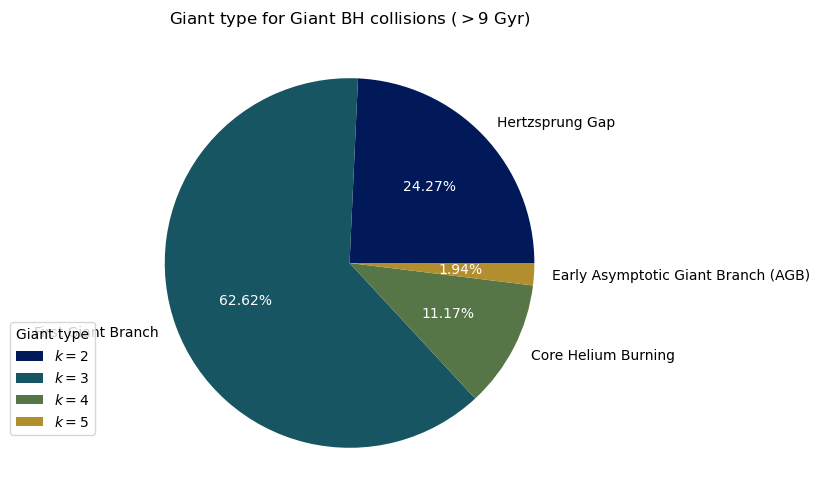

In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.pie(fractions_old, labels=giant_name_types_old, autopct='%1.2f%%', colors=colors)

for autotext in scatter[2]:
    autotext.set_color('white')


ax.set_title(r'Giant type for Giant BH collisions ($> 9$ Gyr)')
ax.legend(scatter[0], giant_types_old, title='Giant type', loc='center left', bbox_to_anchor=(-0.25, -0.25, 0.5, 1))

In [ ]:
# Load the CSV file into a numpy array
data = np.loadtxt(output_file_all, delimiter=',', dtype=str, skiprows=1)


data[0][:4]

array(['16.0', '0.5', '2.0', '0.002'], dtype='<U18')

In [ ]:
from collections import Counter

Model ['16.0' '0.5' '2.0' '0.002']
['0', '0', '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1']


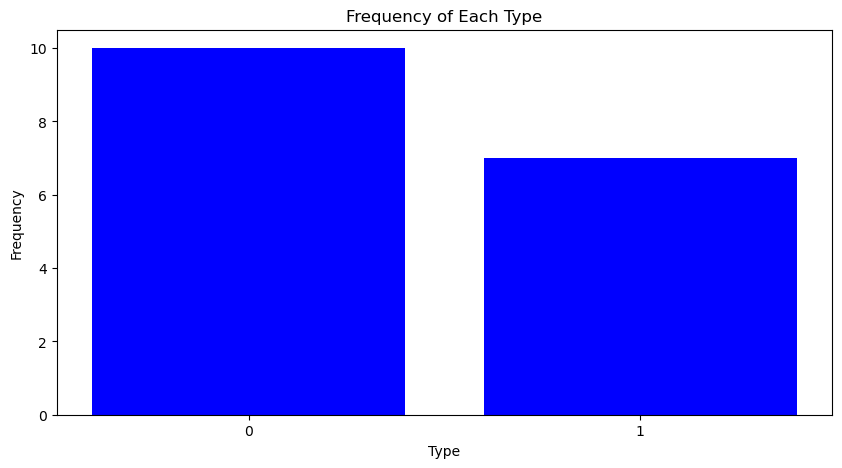

Model ['16.0' '0.5' '2.0' '0.02']
['0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0']


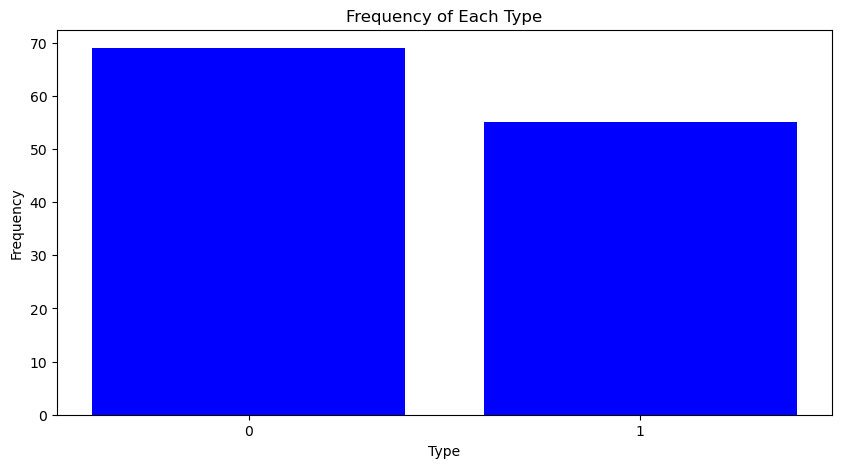

Model ['16.0' '0.5' '20.0' '0.002']
['1', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1']


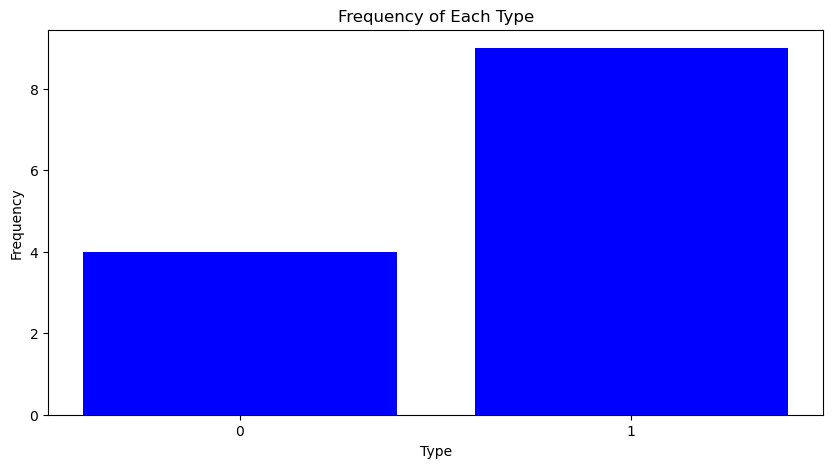

Model ['16.0' '0.5' '20.0' '0.02']
['1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0']


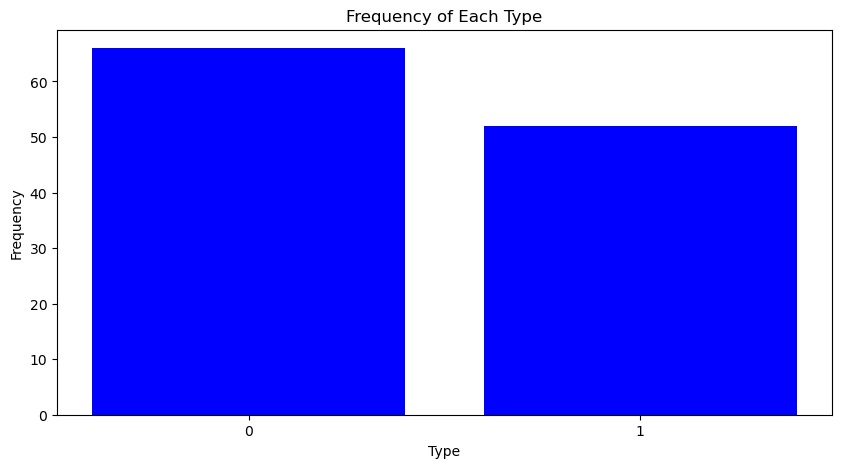

Model ['16.0' '0.5' '8.0' '0.002']
['0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0']


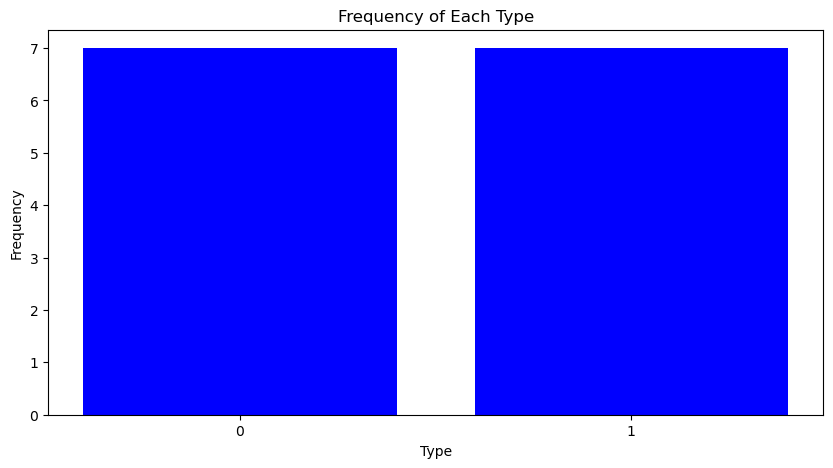

Model ['16.0' '0.5' '8.0' '0.02']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0']


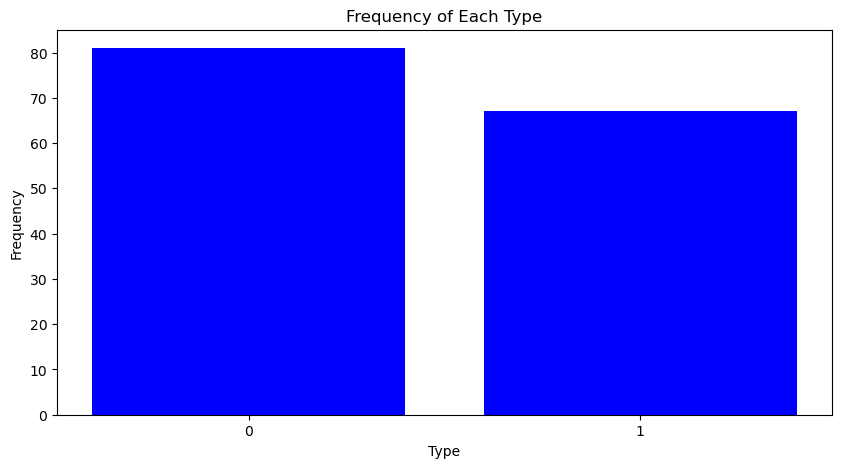

Model ['16.0' '1.0' '2.0' '0.0002']
[]


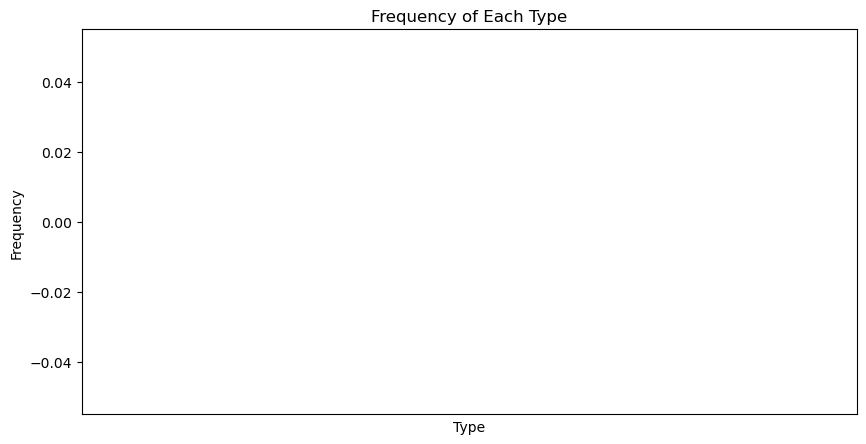

Model ['16.0' '1.0' '2.0' '0.002']
[]


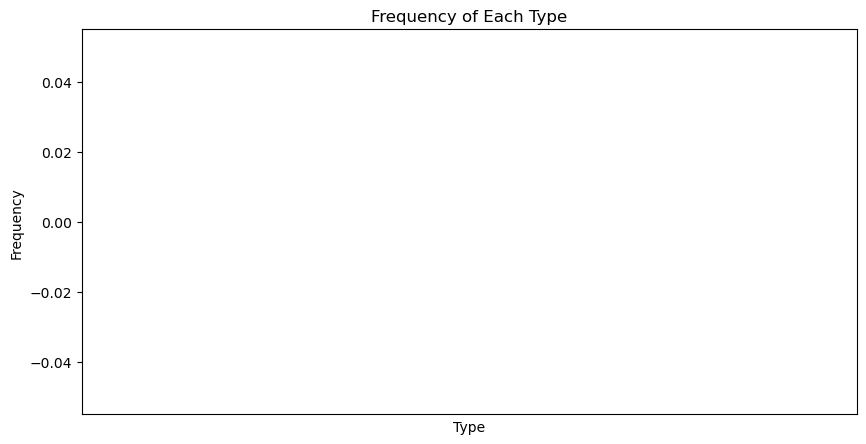

Model ['16.0' '1.0' '2.0' '0.02']
['1', '1', '1', '0', '1']


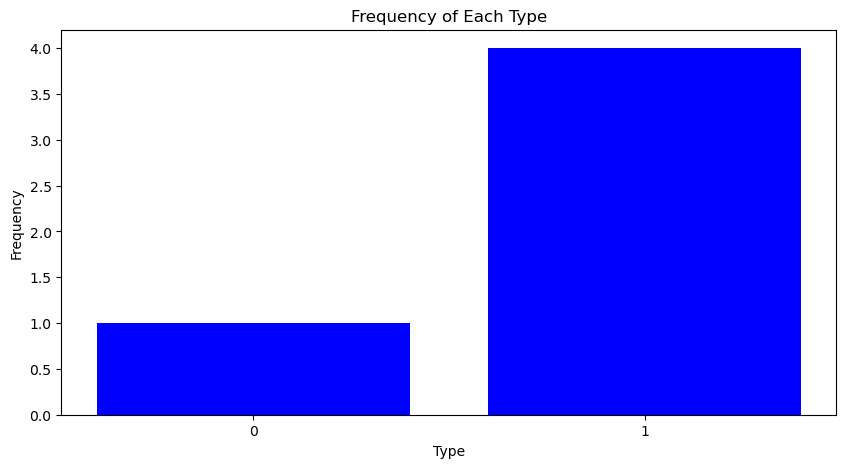

Model ['16.0' '1.0' '20.0' '0.0002']
[]


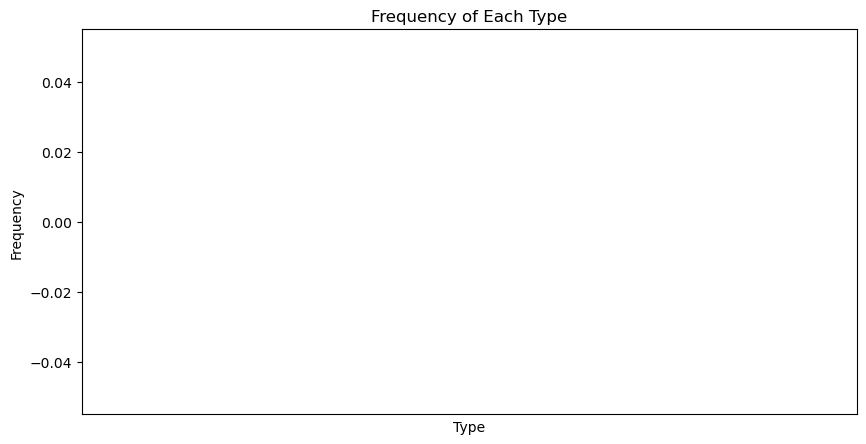

Model ['16.0' '1.0' '20.0' '0.002']
['1']


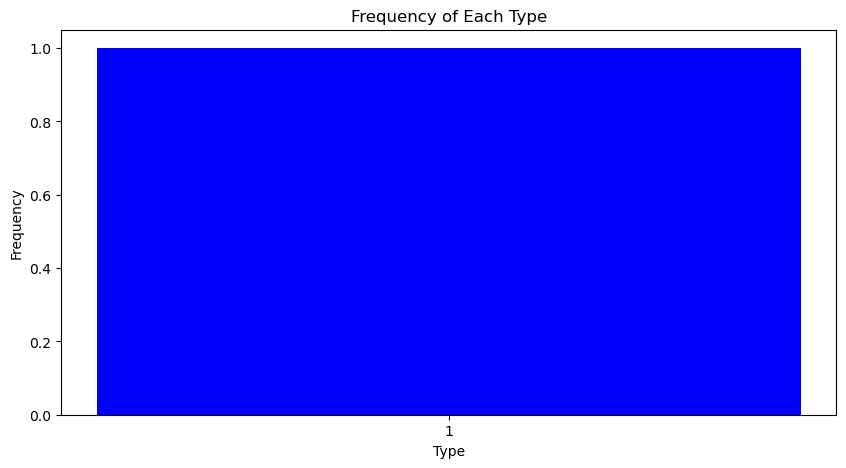

Model ['16.0' '1.0' '20.0' '0.02']
['1', '0', '1', '1', '0', '1']


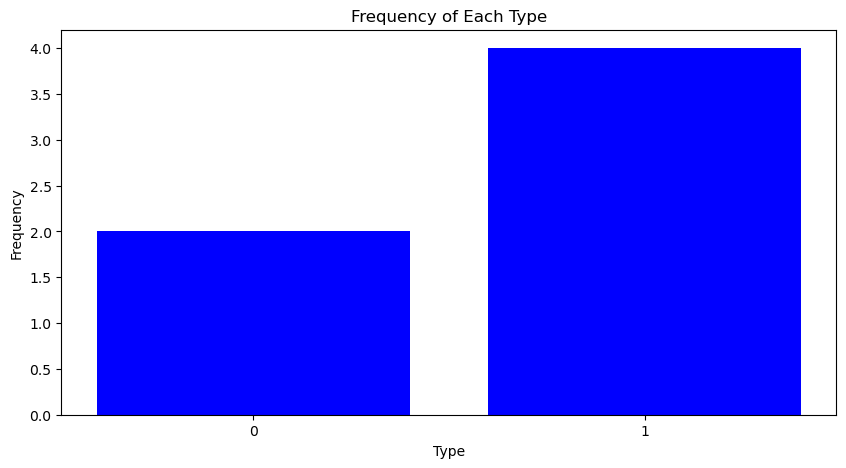

Model ['16.0' '1.0' '8.0' '0.0002']
[]


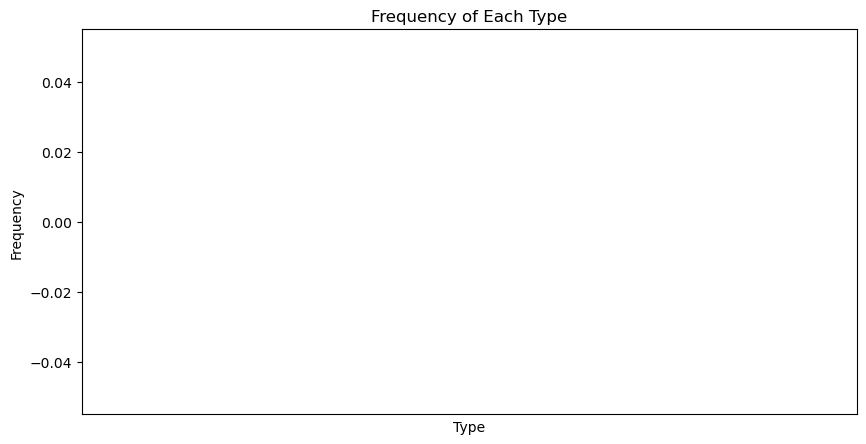

Model ['16.0' '1.0' '8.0' '0.002']
[]


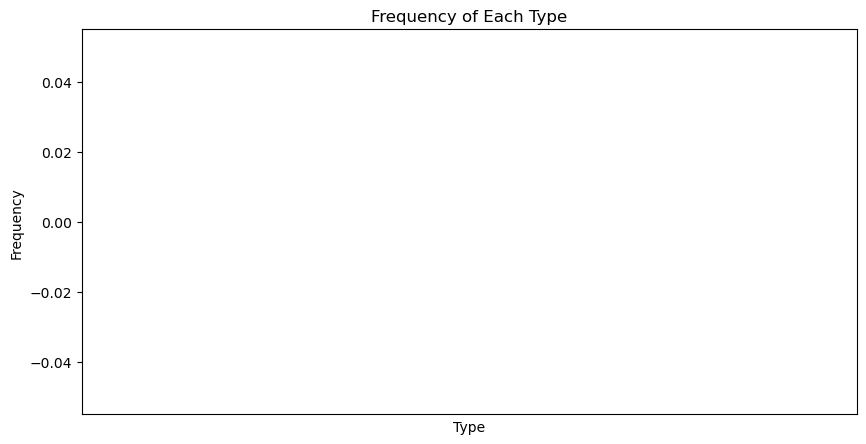

Model ['16.0' '1.0' '8.0' '0.02']
[]


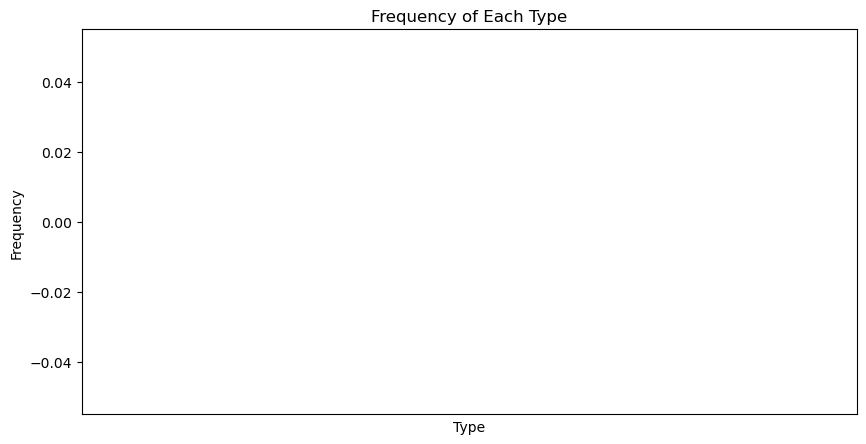

Model ['16.0' '2.0' '2.0' '0.0002']
[]


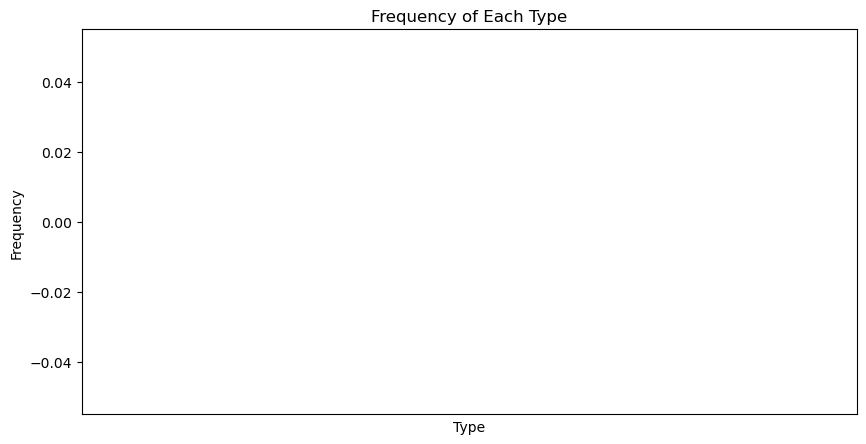

Model ['16.0' '2.0' '2.0' '0.002']
[]


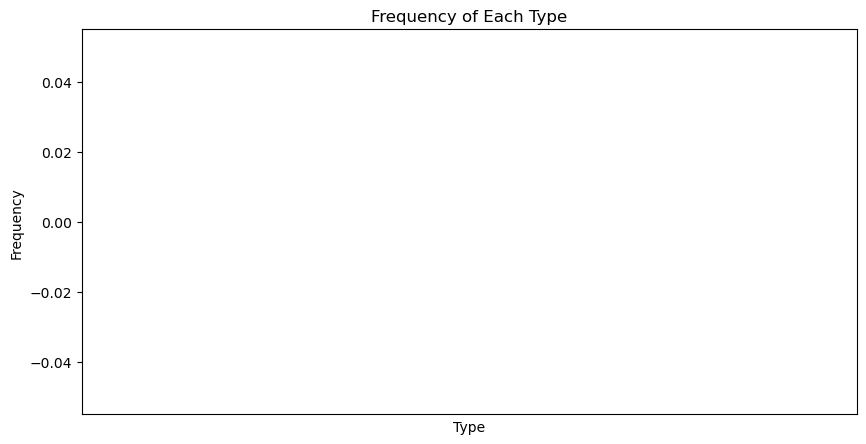

Model ['16.0' '2.0' '2.0' '0.02']
[]


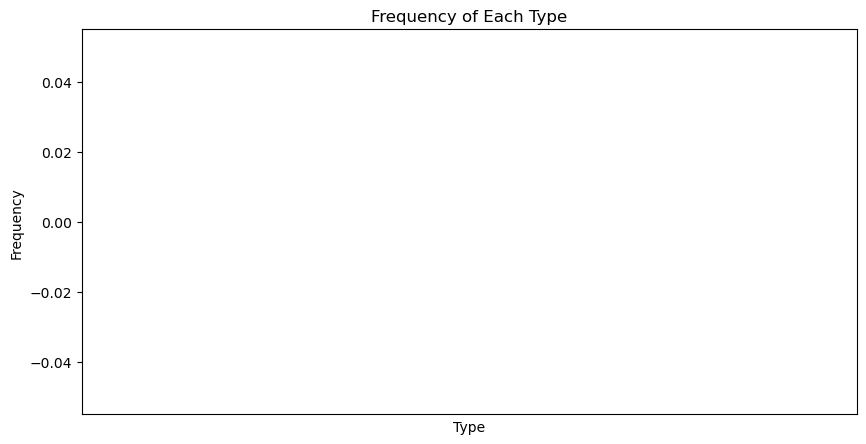

Model ['16.0' '2.0' '20.0' '0.0002']
[]


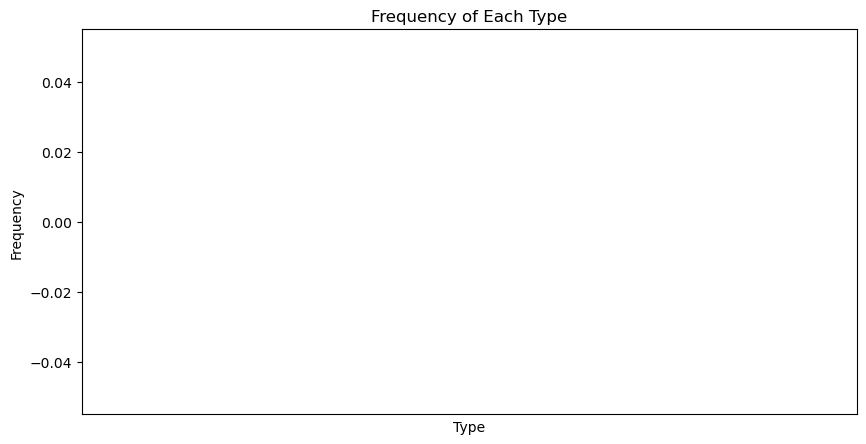

Model ['16.0' '2.0' '20.0' '0.002']
[]


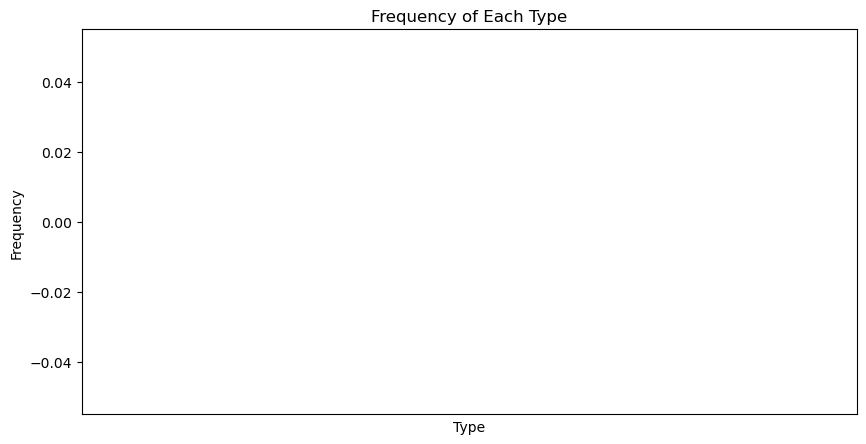

Model ['16.0' '2.0' '20.0' '0.02']
[]


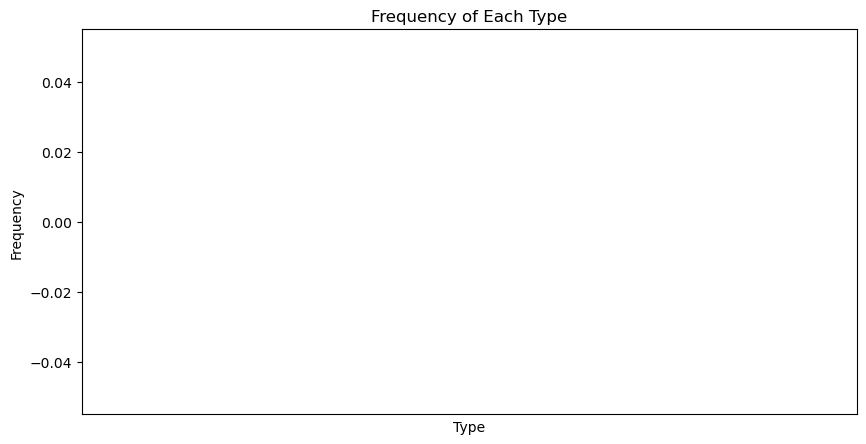

Model ['16.0' '2.0' '8.0' '0.0002']
[]


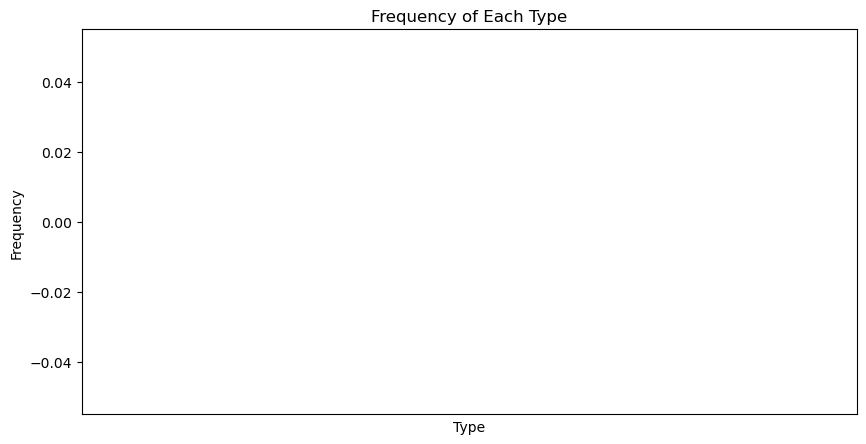

Model ['16.0' '2.0' '8.0' '0.002']
[]


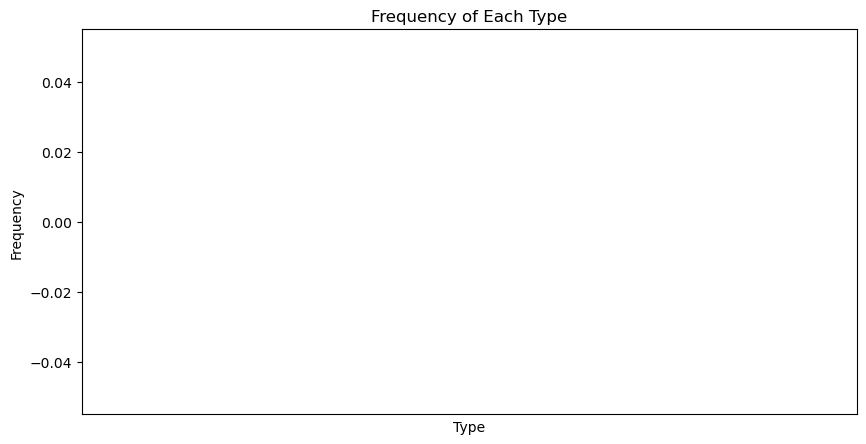

Model ['16.0' '2.0' '8.0' '0.02']
[]


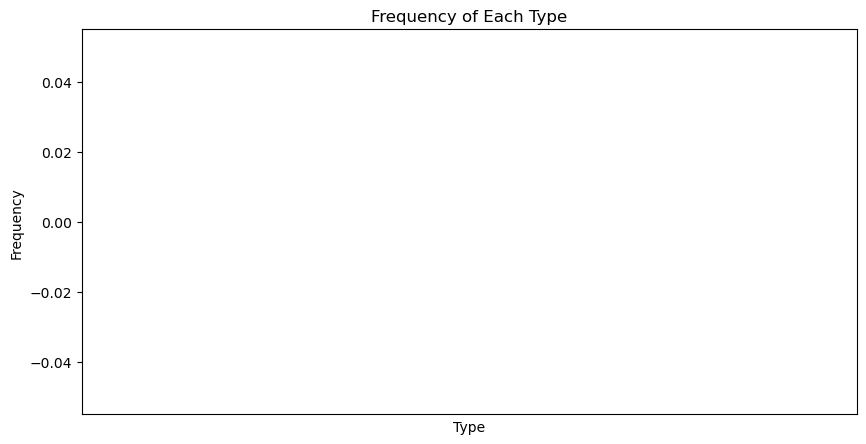

Model ['16.0' '4.0' '2.0' '0.0002']
[]


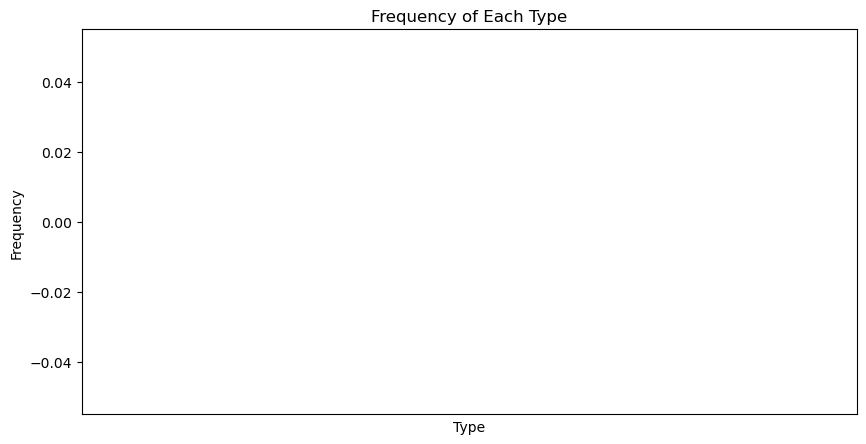

Model ['16.0' '4.0' '2.0' '0.002']
[]


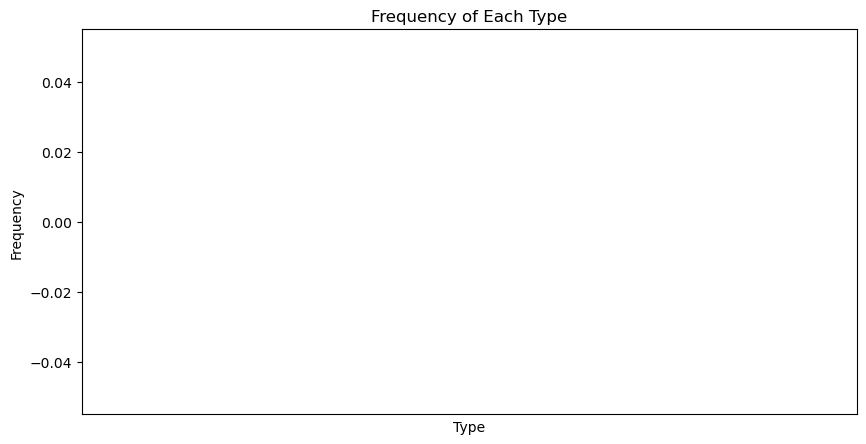

Model ['16.0' '4.0' '2.0' '0.02']
[]


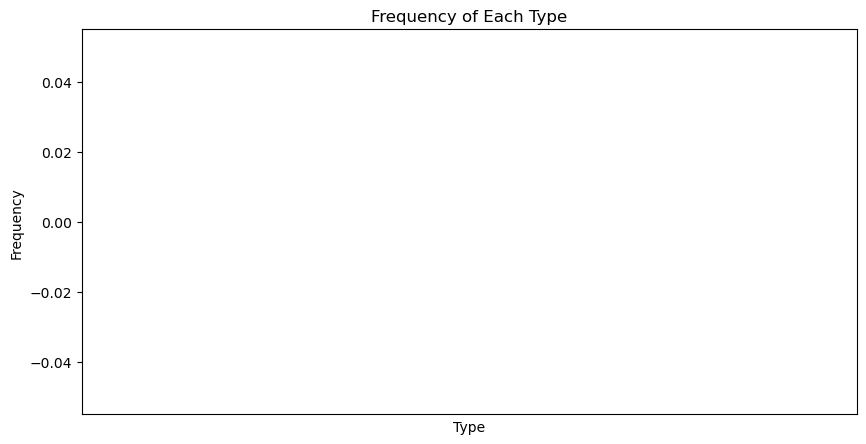

Model ['16.0' '4.0' '20.0' '0.0002']
[]


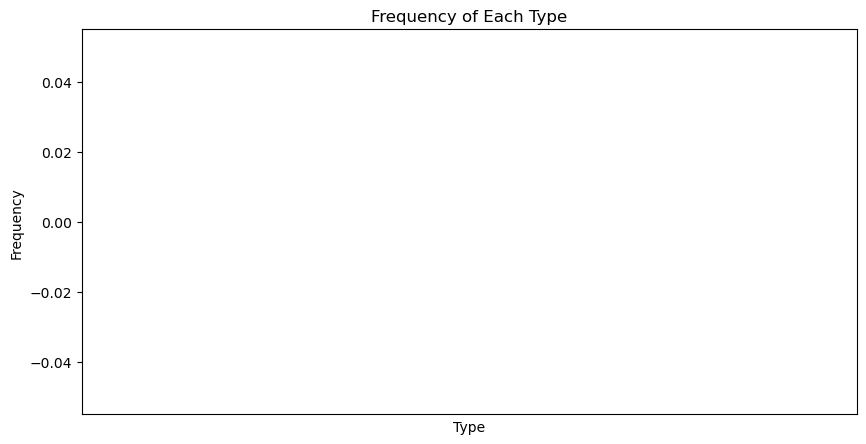

Model ['16.0' '4.0' '20.0' '0.002']
[]


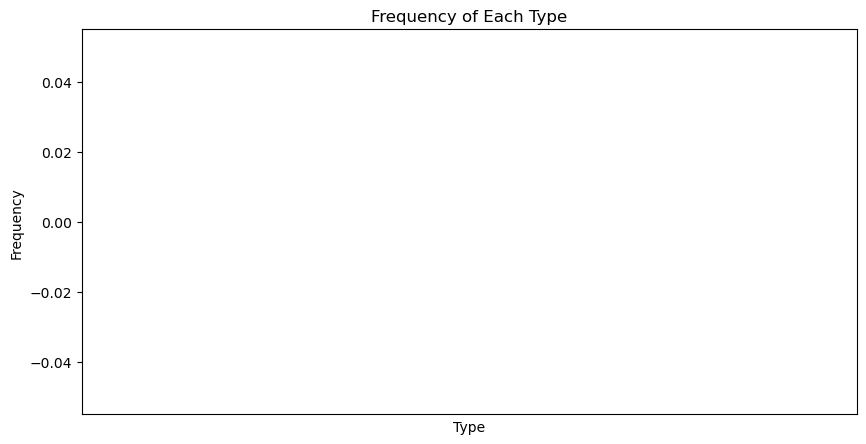

Model ['16.0' '4.0' '20.0' '0.02']
[]


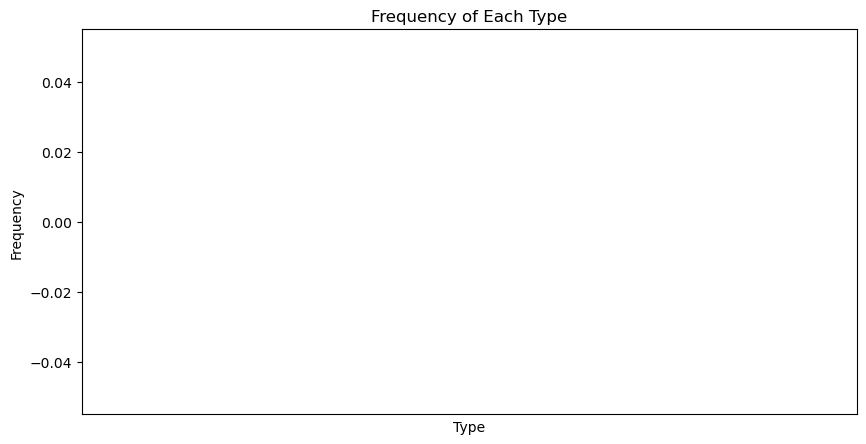

Model ['16.0' '4.0' '8.0' '0.0002']
[]


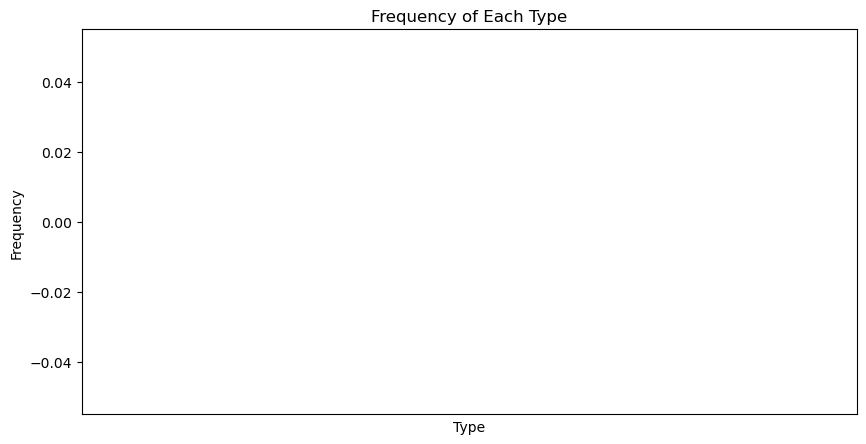

Model ['16.0' '4.0' '8.0' '0.002']
[]


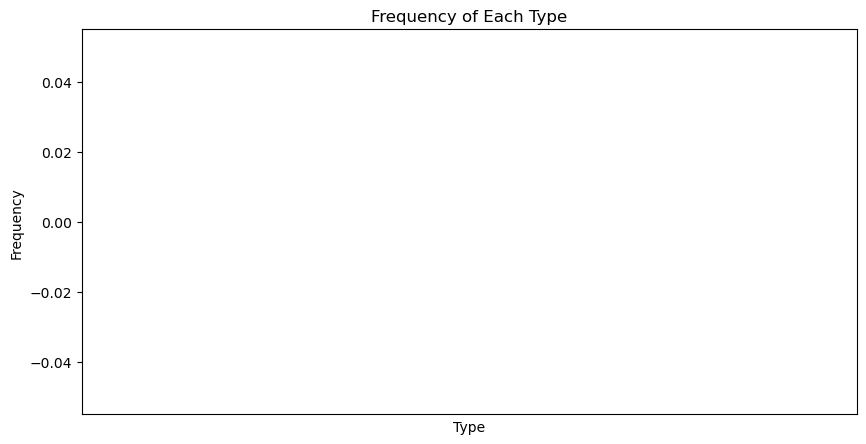

Model ['16.0' '4.0' '8.0' '0.02']
[]


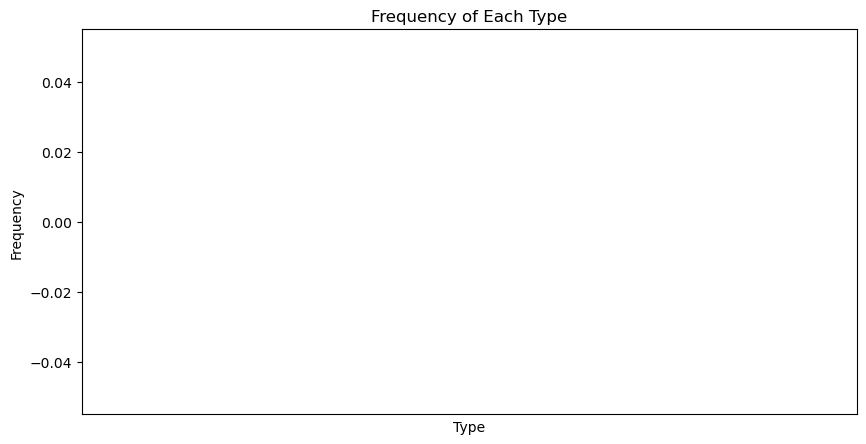

Model ['2.0' '0.5' '2.0' '0.0002']
[]


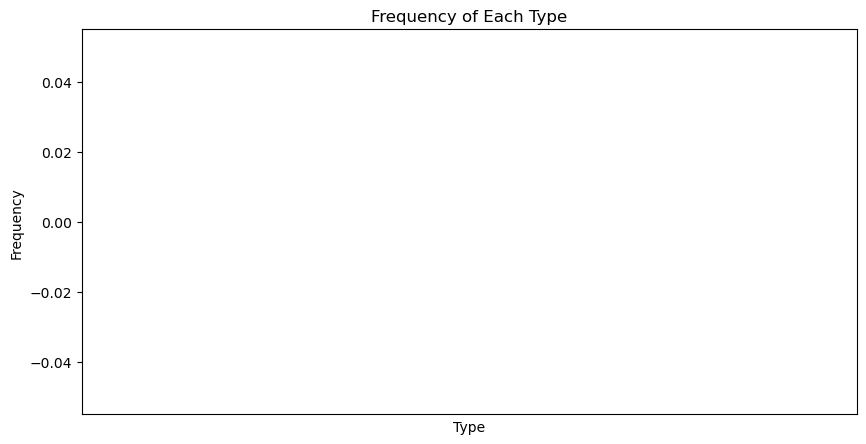

Model ['2.0' '0.5' '2.0' '0.002']
[]


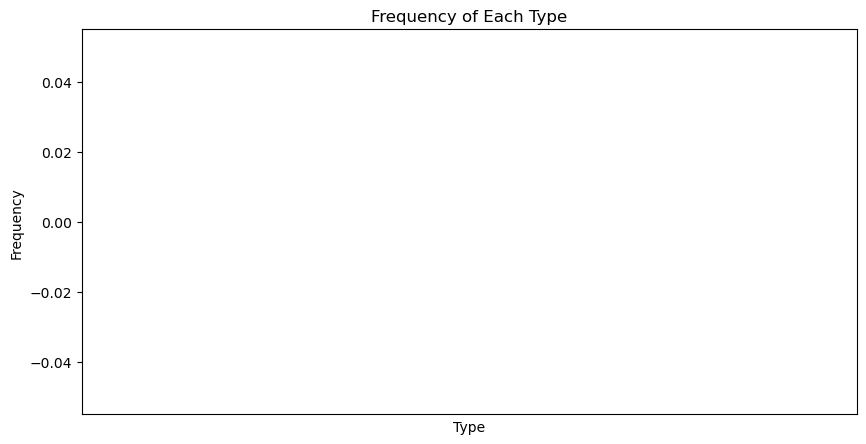

Model ['2.0' '0.5' '2.0' '0.02']
[]


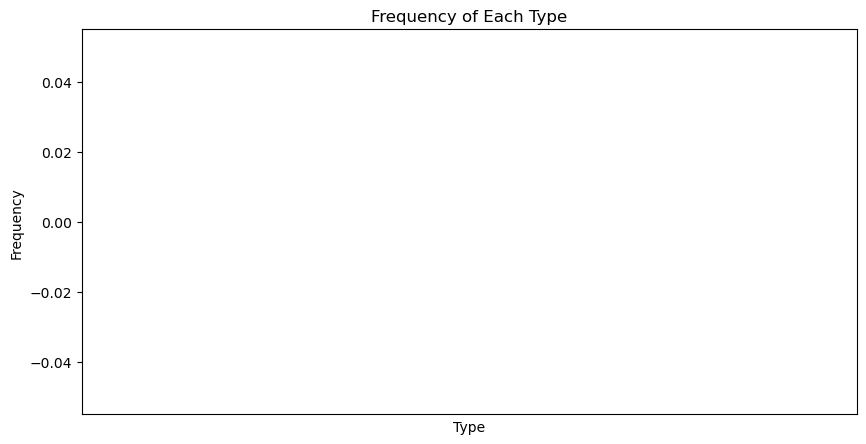

Model ['2.0' '0.5' '20.0' '0.0002']
[]


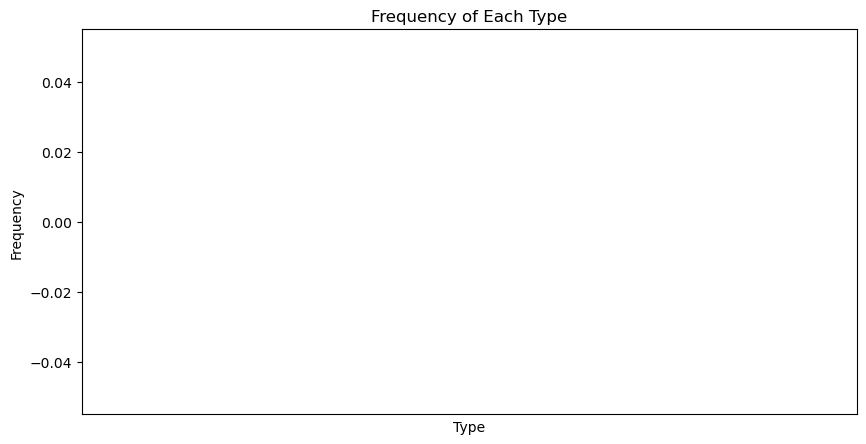

Model ['2.0' '0.5' '20.0' '0.002']
[]


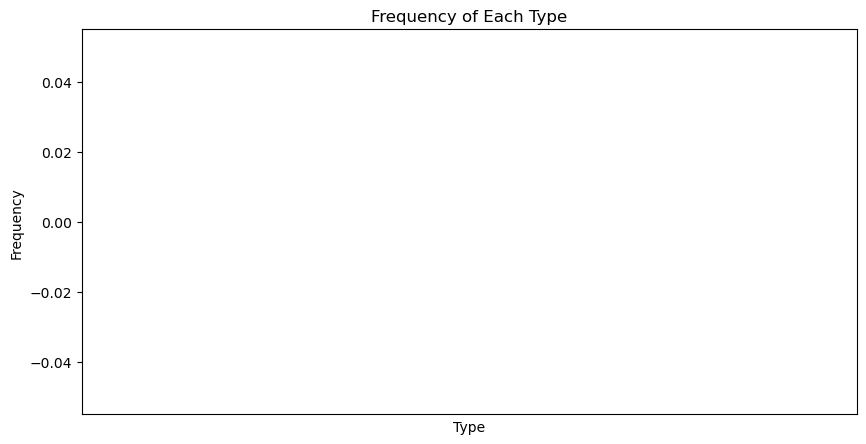

Model ['2.0' '0.5' '20.0' '0.02']
[]


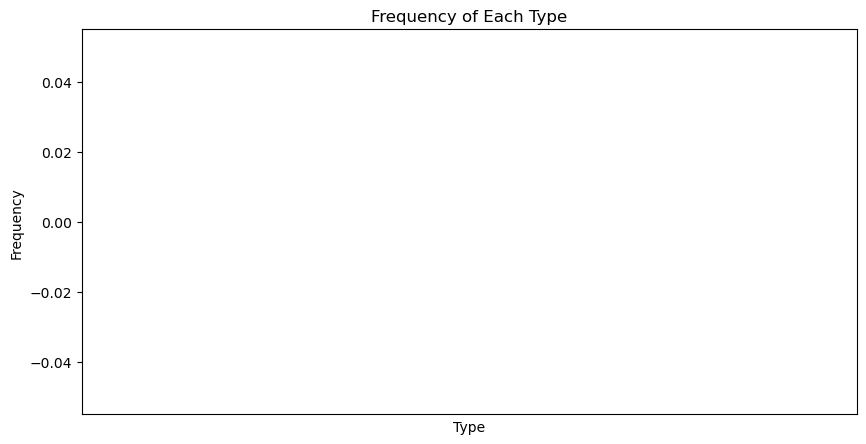

Model ['2.0' '0.5' '8.0' '0.0002']
[]


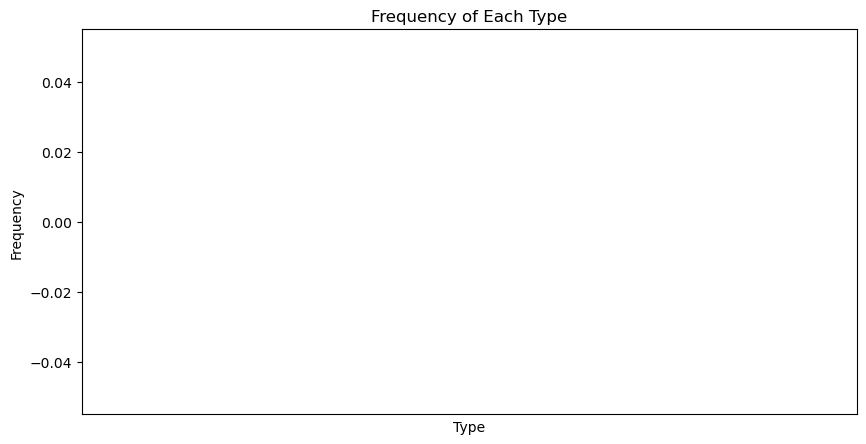

Model ['2.0' '0.5' '8.0' '0.002']
[]


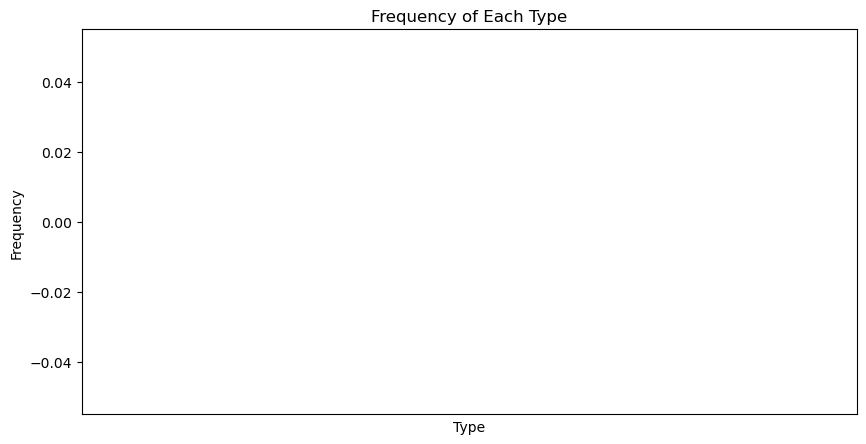

Model ['2.0' '0.5' '8.0' '0.02']
[]


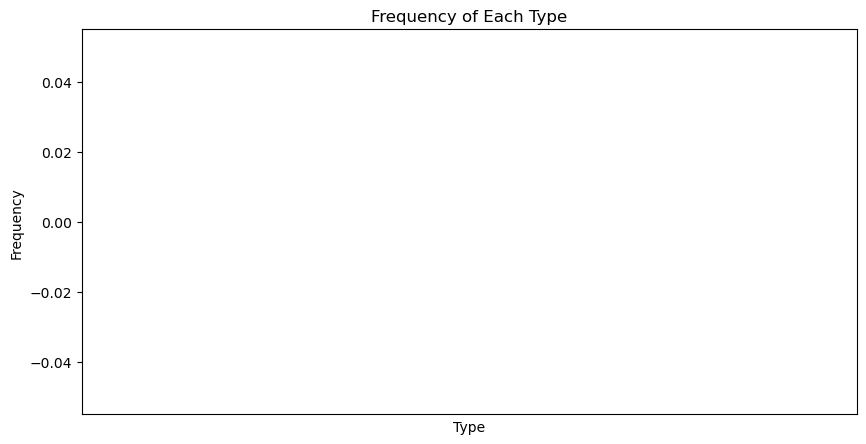

Model ['2.0' '1.0' '2.0' '0.0002']
['1']


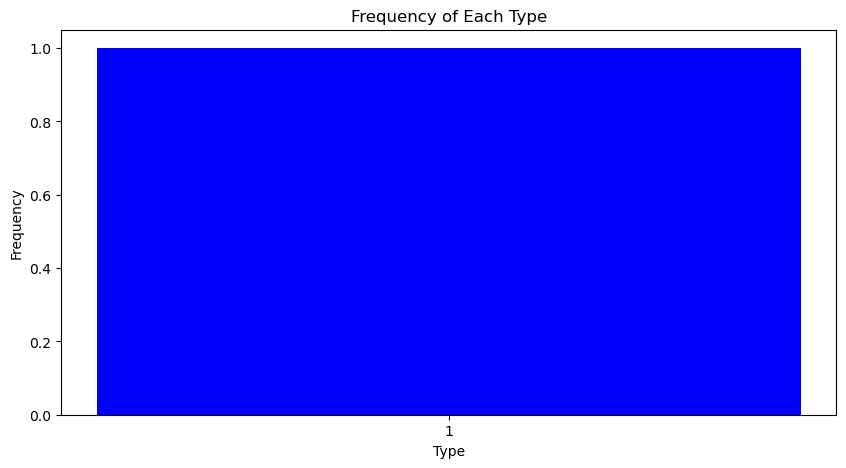

Model ['2.0' '1.0' '2.0' '0.002']
[]


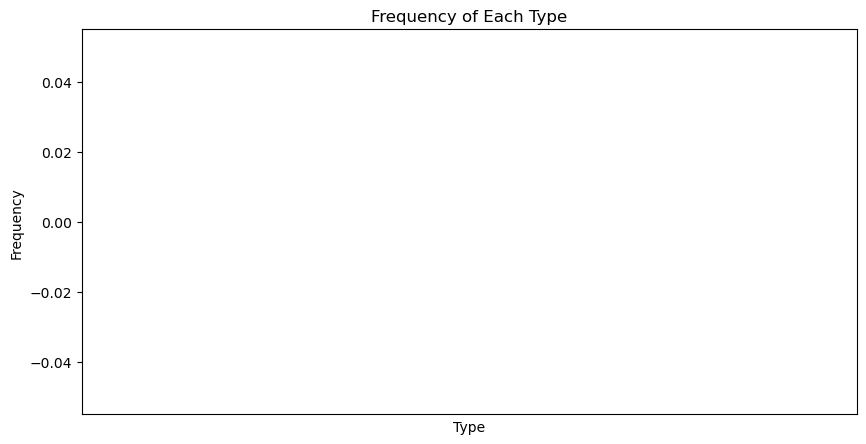

Model ['2.0' '1.0' '2.0' '0.02']
[]


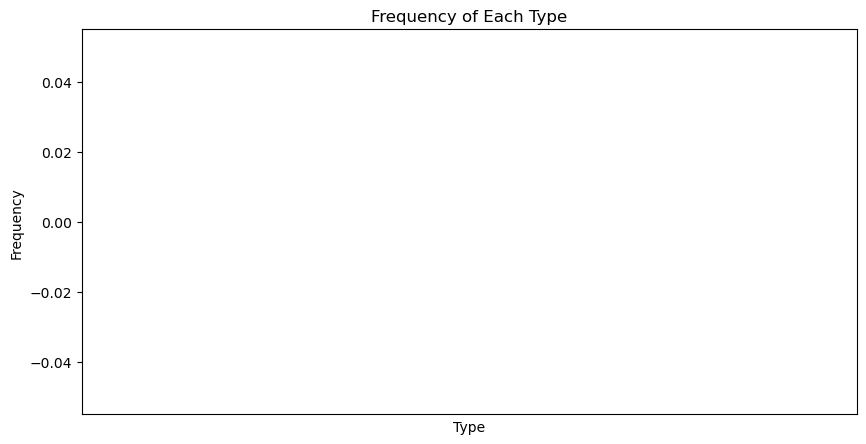

Model ['2.0' '1.0' '20.0' '0.0002']
[]


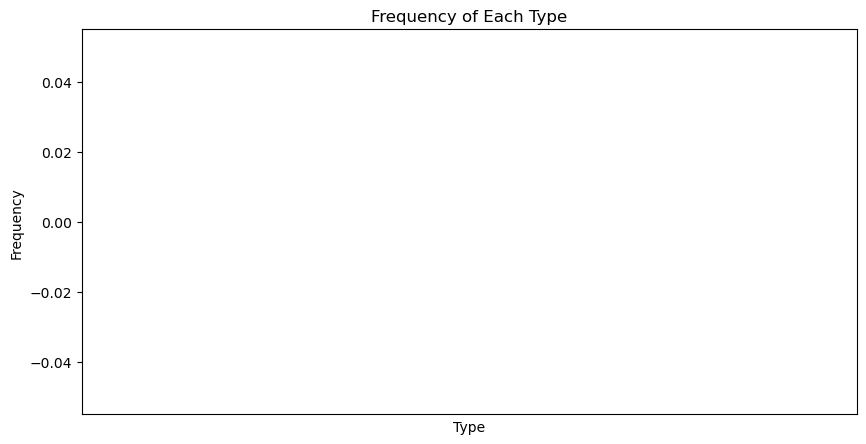

Model ['2.0' '1.0' '20.0' '0.002']
[]


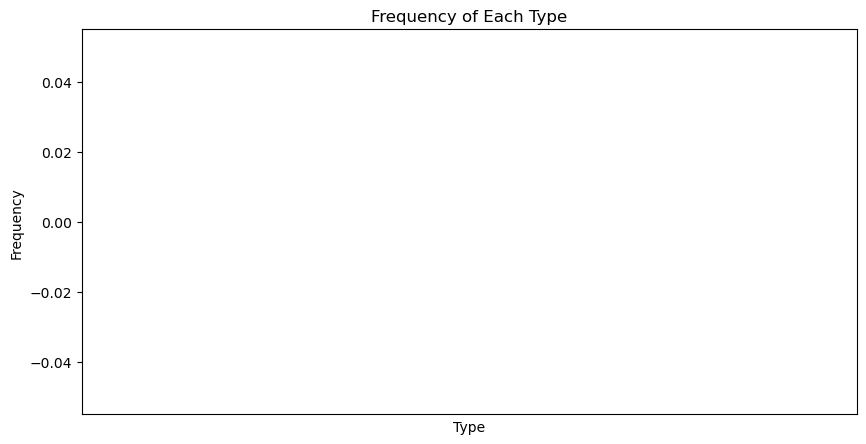

Model ['2.0' '1.0' '20.0' '0.02']
[]


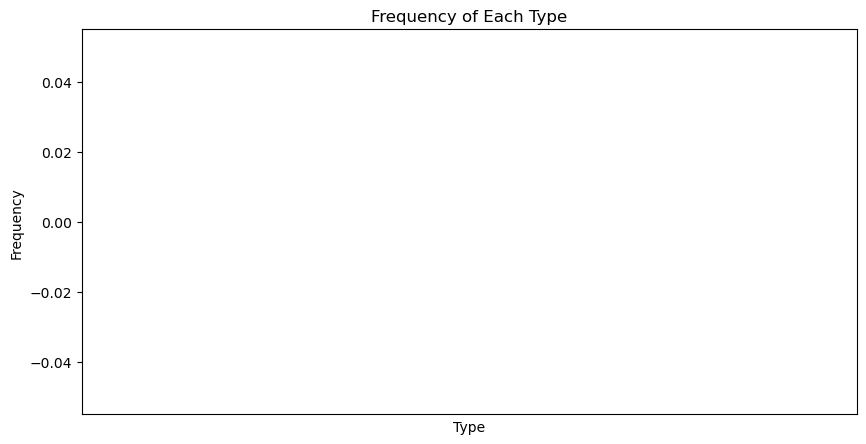

Model ['2.0' '1.0' '8.0' '0.0002']
[]


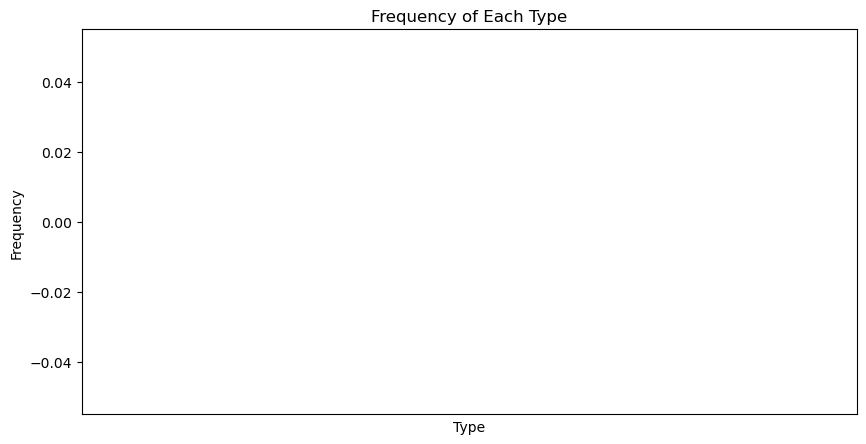

Model ['2.0' '1.0' '8.0' '0.002']
[]


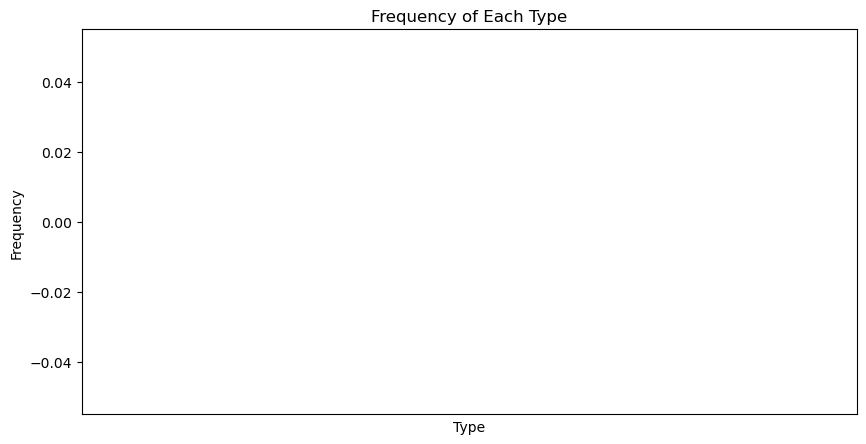

Model ['2.0' '1.0' '8.0' '0.02']
[]


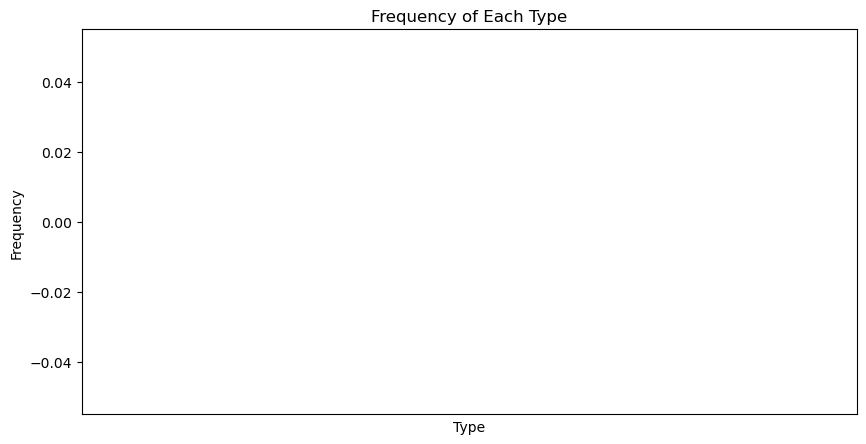

Model ['2.0' '2.0' '2.0' '0.0002']
[]


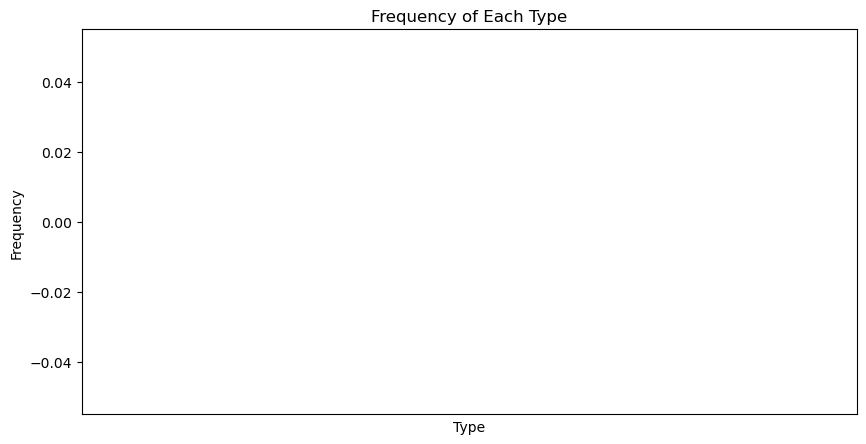

Model ['2.0' '2.0' '2.0' '0.002']
[]


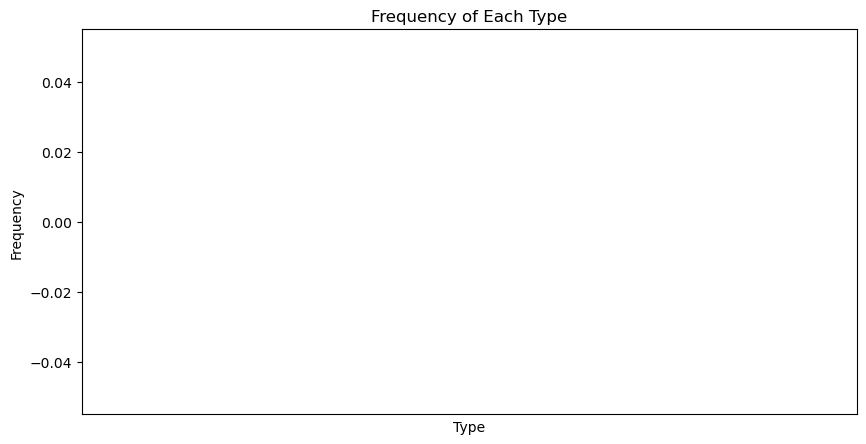

Model ['2.0' '2.0' '2.0' '0.02']
[]


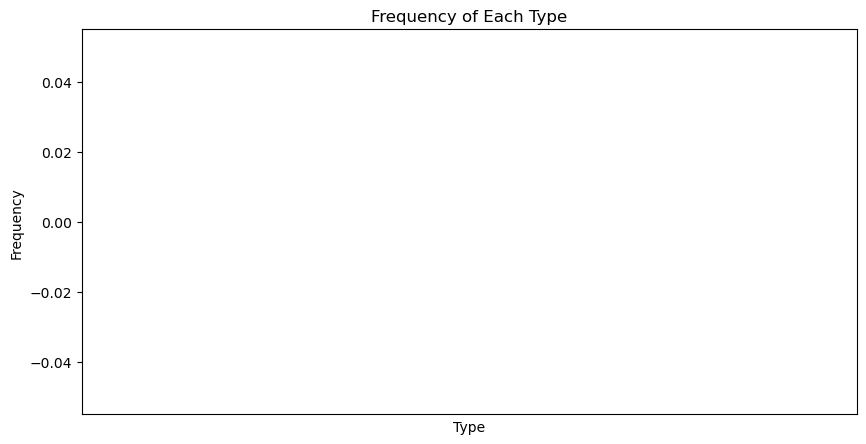

Model ['2.0' '2.0' '20.0' '0.0002']
[]


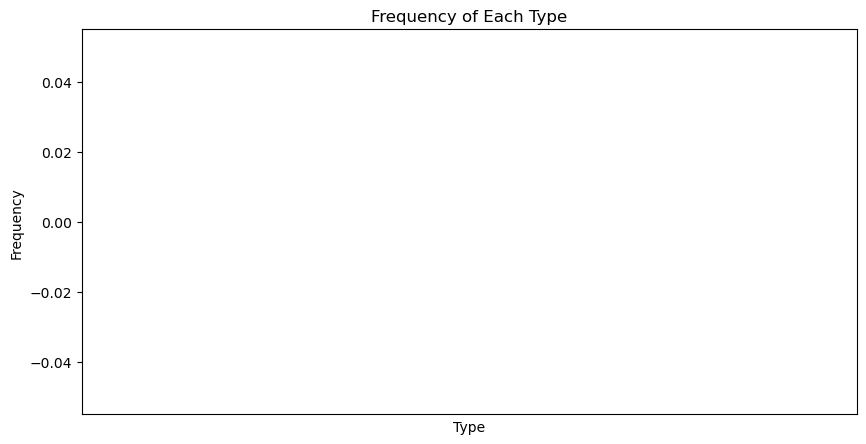

Model ['2.0' '2.0' '20.0' '0.002']
[]


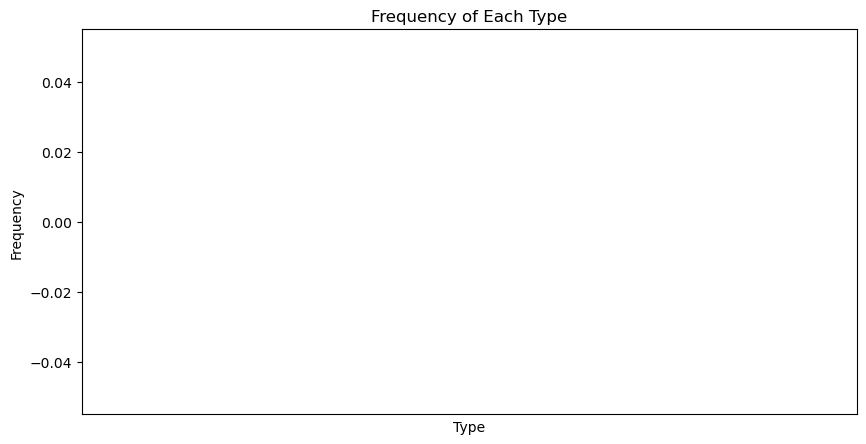

Model ['2.0' '2.0' '20.0' '0.02']
[]


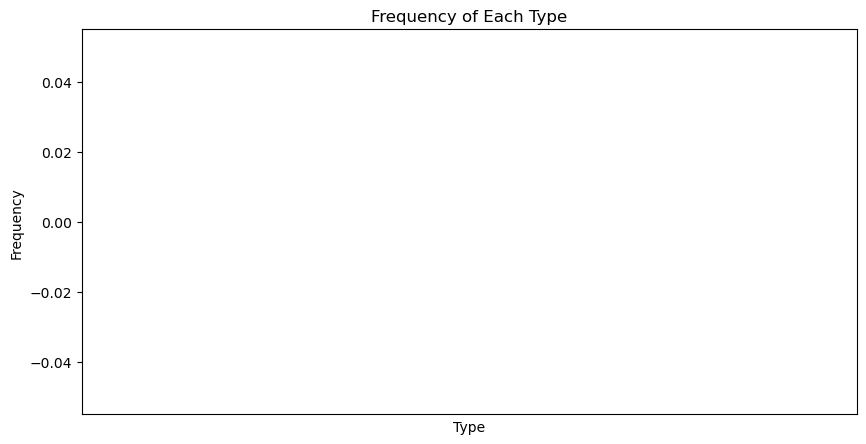

Model ['2.0' '2.0' '8.0' '0.0002']
[]


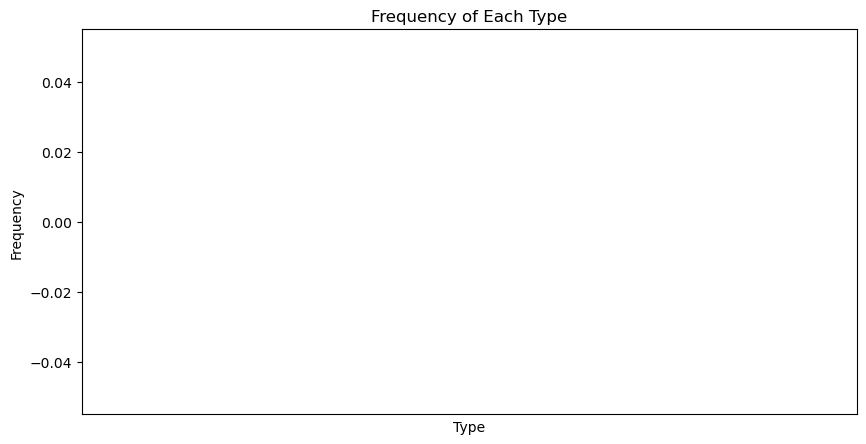

Model ['2.0' '2.0' '8.0' '0.002']
[]


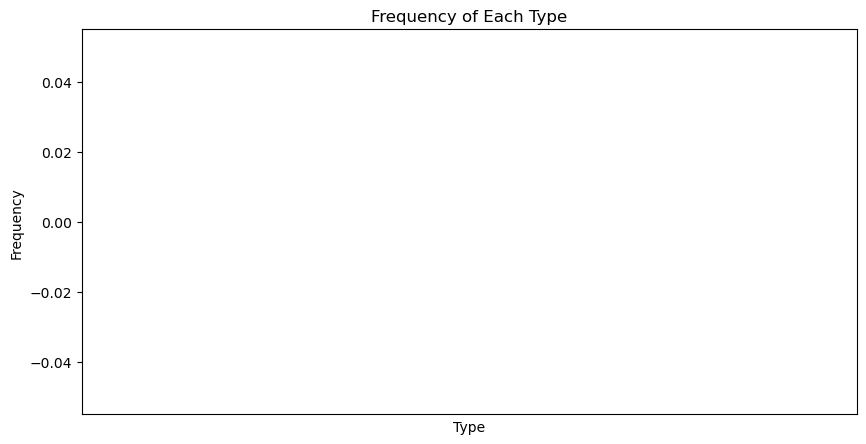

Model ['2.0' '2.0' '8.0' '0.02']
[]


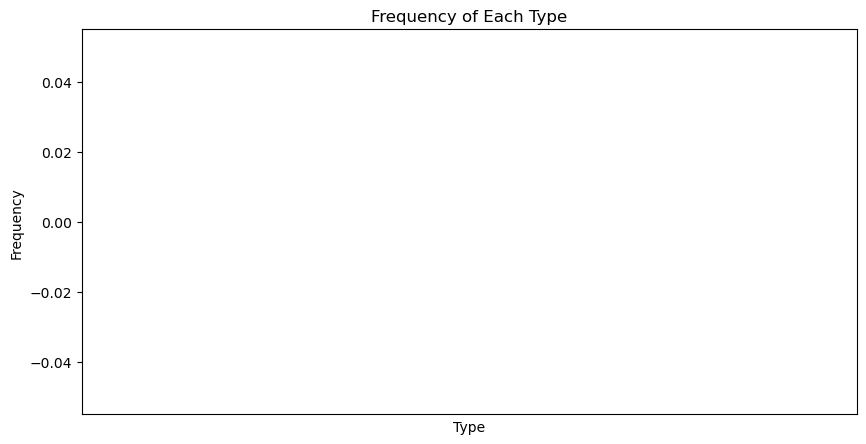

Model ['2.0' '4.0' '2.0' '0.0002']
[]


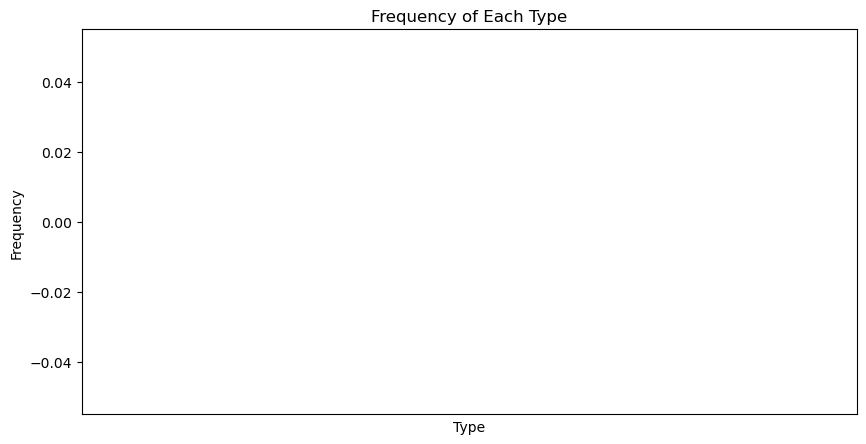

Model ['2.0' '4.0' '2.0' '0.002']
[]


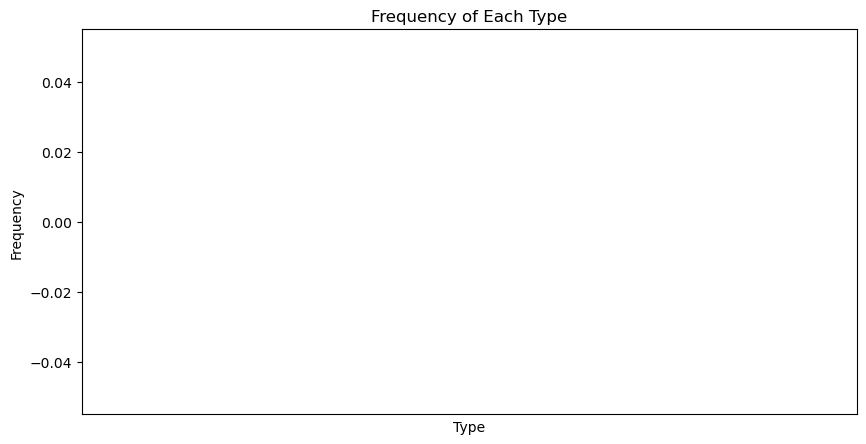

Model ['2.0' '4.0' '2.0' '0.02']
[]


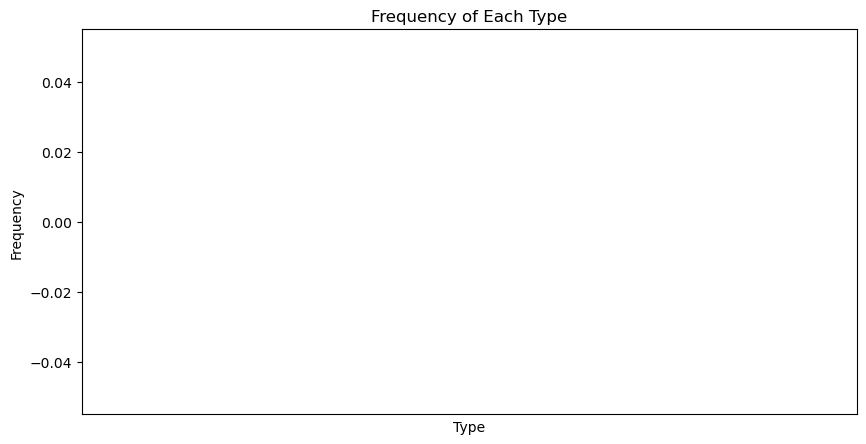

Model ['2.0' '4.0' '20.0' '0.0002']
[]


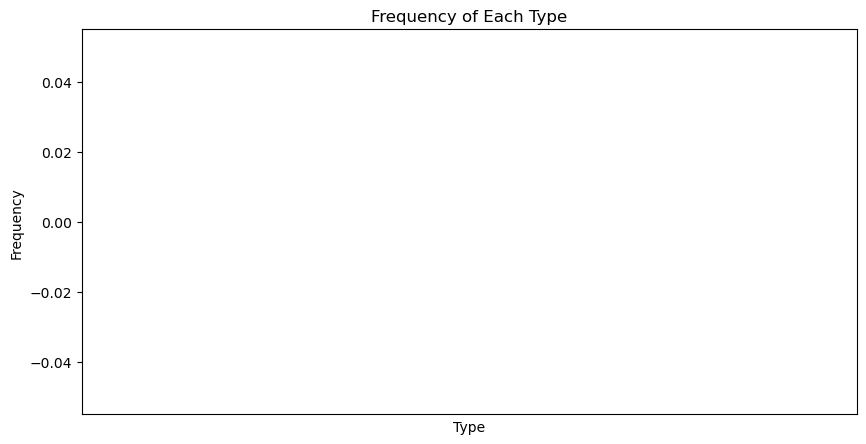

Model ['2.0' '4.0' '20.0' '0.002']
[]


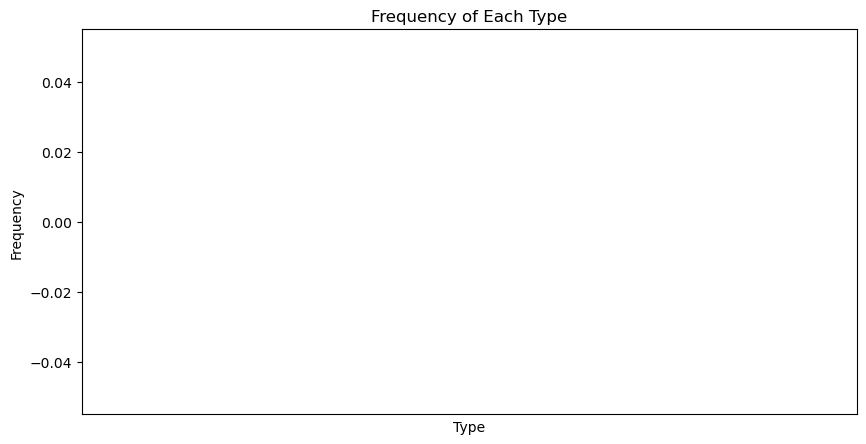

Model ['2.0' '4.0' '20.0' '0.02']
[]


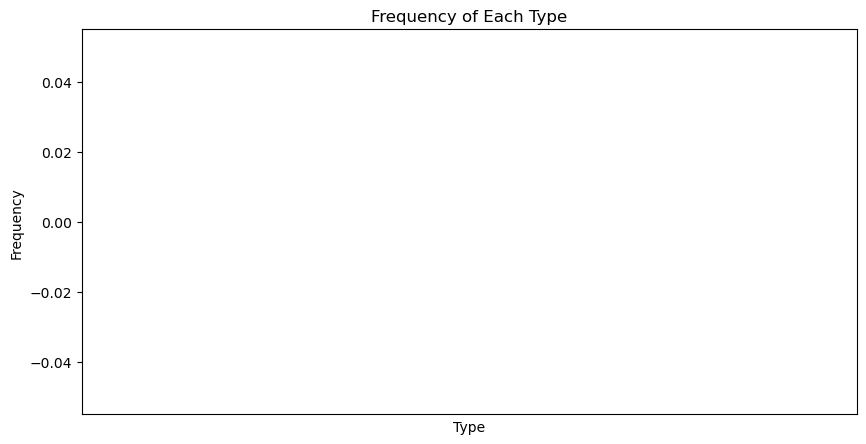

Model ['2.0' '4.0' '8.0' '0.0002']
[]


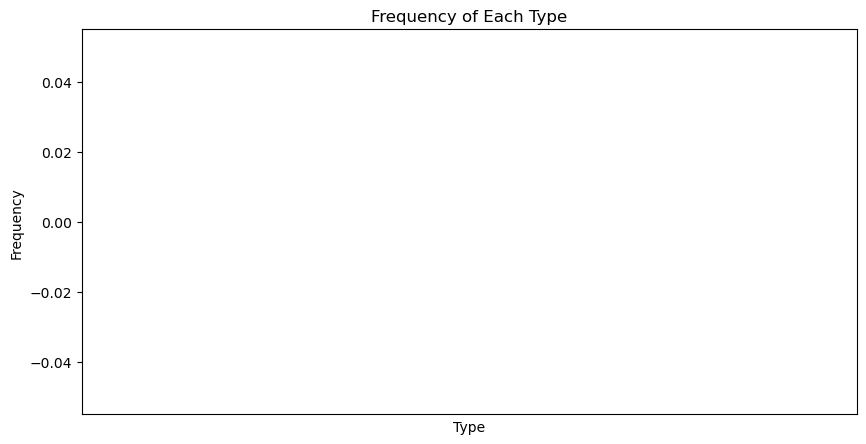

Model ['2.0' '4.0' '8.0' '0.002']
[]


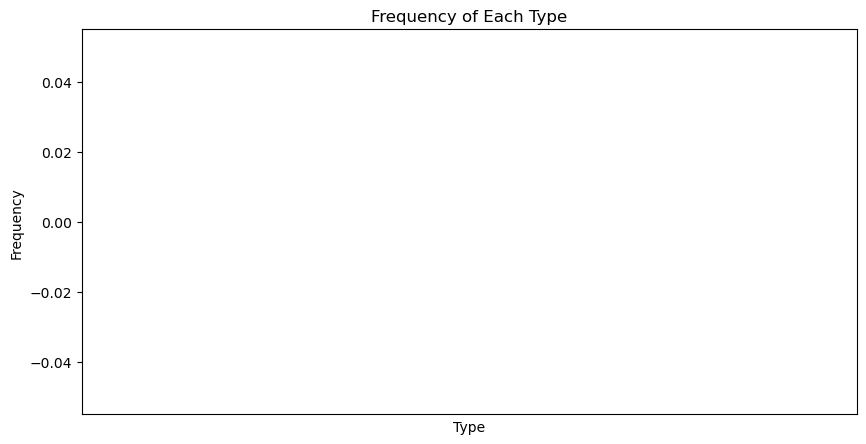

Model ['2.0' '4.0' '8.0' '0.02']
[]


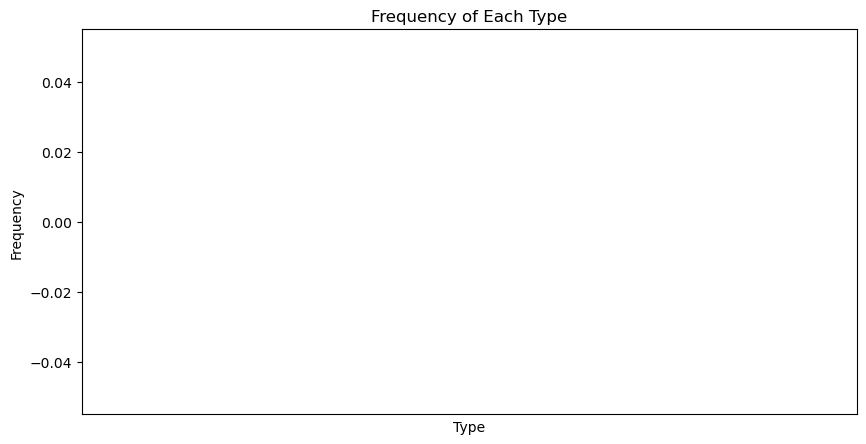

Model ['32.0' '1.0' '20.0' '0.0002']
[]


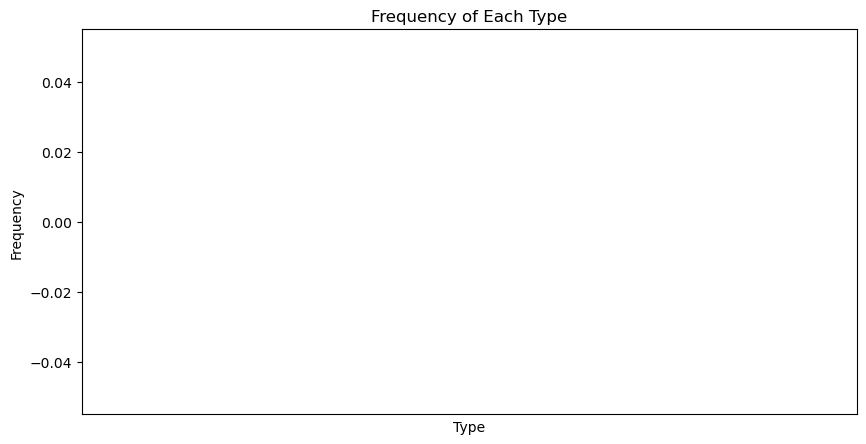

Model ['32.0' '1.0' '20.0' '0.02']
[]


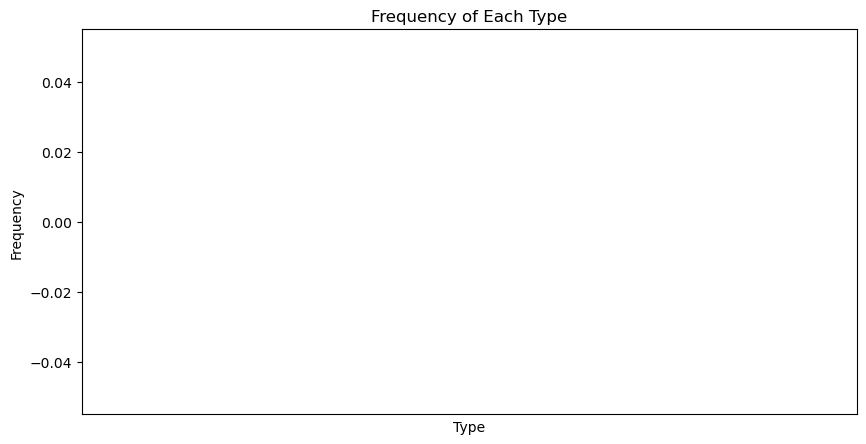

Model ['32.0' '2.0' '20.0' '0.0002']
[]


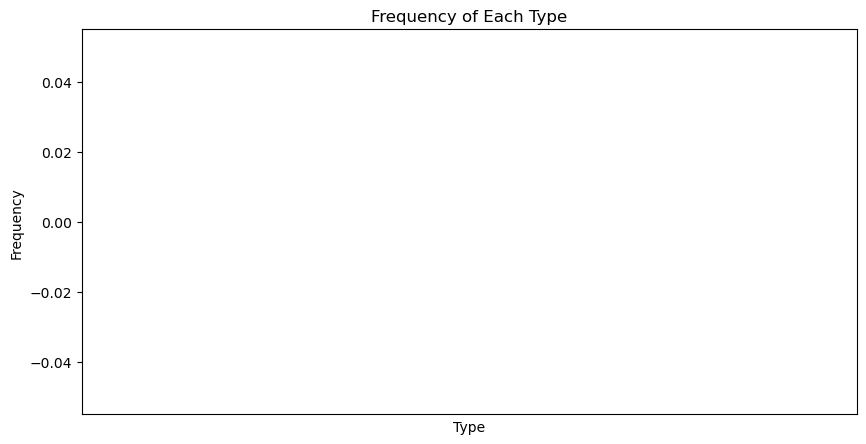

Model ['32.0' '2.0' '20.0' '0.02']
[]


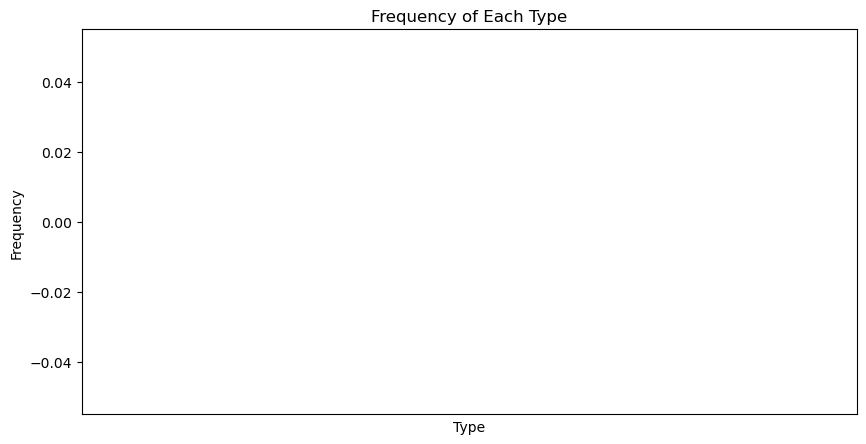

Model ['4.0' '0.5' '2.0' '0.0002']
[]


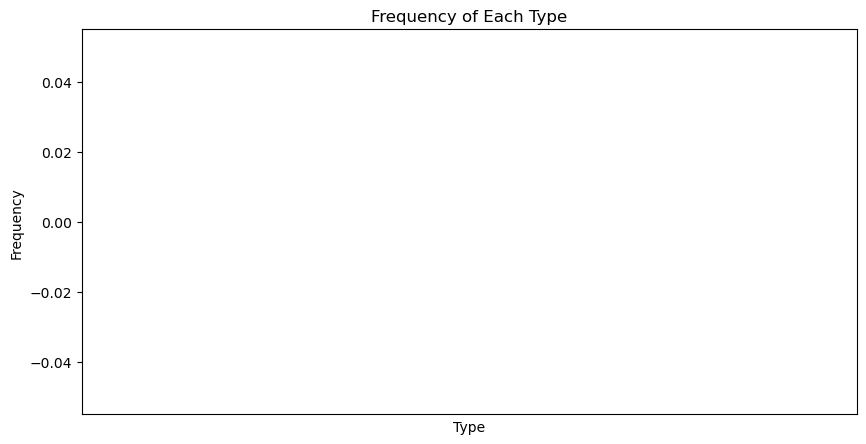

In [ ]:
# Load the CSV file
data_iscollision = np.loadtxt(output_file_iscollision, delimiter=',', dtype=str, skiprows=1)

# Load the CSV file
data = np.loadtxt(output_file_all_all, delimiter=',', dtype=str, skiprows=1)

# Extract the first four columns (model parameters) and the rest (collision events)
model_params = data[:, :4]
collision_events = data[:, 4:]

# Get unique combinations of model parameters
unique_params = np.unique(model_params, axis=0)



# Extract the first four columns (model parameters) and the rest (collision events)
model_params_iscollision = data_iscollision[:, :4]
collision_events_iscollision = data_iscollision[:, 4:]

# Get unique combinations of model parameters
unique_params_iscollision = np.unique(model_params_iscollision, axis=0)



# Loop through each unique combination of model parameters
for params, params_iscollision in zip(unique_params, unique_params_iscollision):
    # Find indices where model parameters match the current unique combination
    mask = np.all(model_params == params, axis=1)
    # Find indices where model parameters match the current unique combination
    mask_iscollision = np.all(model_params_iscollision == params_iscollision, axis=1)


    # Get the corresponding collision events
    matching_events = data[mask]
    matching_events_iscollision = data_iscollision[mask_iscollision]
    
    print(f"Model {params}")
    
    # Check for matching ID
    merger_column = matching_events_iscollision[:, 6]
    col_9 = matching_events[:, 8]
    col_11 = matching_events[:, 10]
    
    types = []

    for i, merger_id in enumerate(merger_column):
        if merger_id in col_9 or merger_id in col_11:
            types.append(matching_events[i, 19])

    print(types)

    # Count the frequency of each integer
    counter = Counter(np.array(types).astype(float))

    # Sort the keys and values
    sorted_items = sorted(counter.items())

    # Handle the case where sorted_items might be empty
    if sorted_items:
        keys, values = zip(*sorted_items)
    else:
        keys, values = [], []

    # Plot the frequencies
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='blue')
    plt.xlabel('Type')
    plt.ylabel('Frequency')
    plt.title('Frequency of Each Type')
    plt.xticks(keys)
    plt.show()

